**Name: Osama Sidahmed**

**Capstone project: Detecting and Predicting Seizure Onset**

**Date Submitted: 11 Apr 2021**

**Notebook: 2_Features_Extraction**

**Notebook order: 2/4**

**Preceding notebooks: `1_Initial_EDA`**

**Following notebooks: `3_Modelling_Detection` and `4_Modelling_Prediction`**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Features-extraction" data-toc-modified-id="Features-extraction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features extraction</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Initial-modeling" data-toc-modified-id="Initial-modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Initial modeling</a></span></li><li><span><a href="#Features-extraction---Dataset_2" data-toc-modified-id="Features-extraction---Dataset_2-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Features extraction - Dataset_2</a></span></li><li><span><a href="#Initial-modeling---Dataset-2" data-toc-modified-id="Initial-modeling---Dataset-2-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Initial modeling - Dataset 2</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Introduction

According to many academic papers on this subject matter, there are three main ways to extract features from the EEG recordings:

- Frequency domain analysis: a study of the data after transforming the time series data into their sequence representation in the frequency dimension using algorithms such as Fast Fourier transform (FFT). There are many algorithms that depend on the FFT to compute the frequency domain representation one of which is the Welsh method that estimates the power density based on short time periods. 
- Time-domain analysis: this is simply dealing with the data in their original nature and deal with the problem as a time-series problem. The main disadvantages of this approach are:
    - The data will be of huge size more than what computers can handle
    - It is known that frequency domain features are more representable of the differences between the classes  
- Time-Frequency domain analysis: is a mix between the two previous approaches but not used as much on this subject matter.

The Frequency domain analysis will be used on this project based on the Welsh method. The Frequency domain carries more representation of the wave characteristics and should provide a better opportunity to differentiate between the classes. The Welsh method is the main method used by `MNE` library. The main advantage of this method is its ability to limit the distortion resulting from the transformation from the time domain to the frequency domain.

This notebook demonstrates the feature extraction process as it was done on my data. The notebook also includes initial modeling done on the data.

*PS: This notebook has been reconstructed from the original notebook that got corrupted.*

# Features extraction

In [4]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# MNE is a library used for brain data manipulation -
# Open-source Python package for exploring, visualizing, and analyzing human neurophysiological data
# https://mne.tools/stable/index.html
import mne

In [125]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Helper function to notify me once a long code block execution is finished - may only work in Windows
import winsound
'''
Helper function to peep once called
'''
def peep_me():
    winsound.Beep(frequency=2500, duration=500)

In [113]:
def precision_recall_f1_scores(y_test, y_pred, m=0):
    '''
    This function takes test target and predicted target and returns the model precision, recall and f1_score scores
    input: Pandas series
    output: 1-D list

    '''
    from sklearn.metrics import precision_score, recall_score, f1_score

    scores = []

    if m == 1:  # multiclass classification
        scores.append(precision_score(y_test, y_pred, average='weighted'))
        scores.append(recall_score(y_test, y_pred, average='weighted'))
        scores.append(f1_score(y_test, y_pred, average='weighted'))
    else:
        scores.append(precision_score(y_test, y_pred))
        scores.append(recall_score(y_test, y_pred))
        scores.append(f1_score(y_test, y_pred))

    return scores

To simplify things, all the `Seizures-list-<patient>.text` files data was aggregated manually in single files `data/dataset_1/seizures_record.csv` for dataset_1 and `data/dataset_2/ds2_seizures_record.csv` for dataset_2. These files contains the registry of the starting and ending times of each seizure, the file atom (observation) is one seizure record. These files will be used to annotate the edf files to extract label the observations correctly. The file is first updated using the following code to change do two things:
- Set the `Registration start time` at 0 and reference all times (`Seizure start time`, `Registration end time` etc..) to the `Registration start time`. This will simplify calculating index of such events on the file.
- Create new calculated columns that will be used by the function such as `seizure time` that represents how any seconds each seizure lasted for.

The resulting file is `data/dataset_1/seizures_record_updated.csv` for dataset_1 and `data/dataset_2/ds2_seizures_record_updated.csv` for dataset_2.

In [6]:
# This funcion takes the time in H.M.S format and converts it to seconds
def normalize_time(es_t):
    '''
    This function changes time `es_t` from H.M.S format to S format

    '''
            
    h, m, s = es_t.split('.')
    t_in_sec  = int(h) * 3600 + int(m) * 60 + int(s)

    return  t_in_sec   

In [ ]:
# Read csv file containing the database annotations and store into a dataframe
df_seizures_record = pd.read_csv(
    dataset_path + '/' + 'seizures_record.csv', index_col='Index')

In [ ]:
# Change the time format from H.M.S format to S format 
df_seizures_record['Registration_start_time'] = df_seizures_record['Registration_start_time'].apply(normalize_time)
df_seizures_record['Registration_end_time'] = df_seizures_record['Registration_end_time'].apply(normalize_time)
df_seizures_record['Seizure_start_time'] = df_seizures_record['Seizure_start_time'].apply(normalize_time)
df_seizures_record['Seizure_end_time']  = df_seizures_record['Seizure_end_time'].apply(normalize_time)

The prefix `n_` denotes the that this column reference is the `Registration_start_time` column. These are new columns as well:
- `Seizure_t` is the seizure time.
- `pre_s_t` is he time before the seizure started.
- `post_s_t`is the time after the seizure has finished.

In [ ]:
# add new columns, 
df_seizures_record['n_Registration_start_time'] = df_seizures_record['Registration_start_time'] - \
    df_seizures_record['Registration_start_time']
df_seizures_record['n_Registration_end_time'] = df_seizures_record['Registration_end_time'] - \
    df_seizures_record['Registration_start_time']
df_seizures_record['n_Seizure_start_time'] = df_seizures_record['Seizure_start_time'] - \
    df_seizures_record['Registration_start_time']
df_seizures_record['n_Seizure_end_time'] = df_seizures_record['Seizure_end_time'] - \
    df_seizures_record['Registration_start_time']

df_seizures_record['Seizure_t'] = df_seizures_record['n_Seizure_end_time'] - \
    df_seizures_record['n_Seizure_start_time']

df_seizures_record['pre_s_t'] = df_seizures_record['n_Seizure_start_time'] - \
    df_seizures_record['n_Registration_start_time']
df_seizures_record['post_s_t'] = df_seizures_record['n_Registration_end_time'] - \
    df_seizures_record['n_Seizure_end_time']

In [ ]:
df_seizures_record

In [ ]:
# write df_seizures_record to csv file
df_seizures_record.to_csv('data/dataset_1/seizures_record_updated.csv')

Before moving forward, let me introduce the concept `epoch`. This term is used on the subject matter and is simply used to denote how many seconds do I take as one unit, i.e. as one observation. This should not be confused with the neural network epoch.

A `time_to_frequency_domain` function that takes one edf file and outputs a dataframe and csv file with n number of features has been constructed. The function works as follows:
- Segments the file in three parts using the data read from the : the time before the seizure, the time during the seizure and the time after the seizure.
- Reads the file using `mne.io.read_raw_edf()` method.
- Loops through the read file in two for loops, the outer one (for target labeling) is based on the event type (before the seizure, during the seizure or after the seizure), the inner for loop is based on the epoch time.
- On every inner loop the function calculates the Welsh power spectral density from the 0.5 to 25 Hz and store that in a dataframe at the end.
- The target labeling is based on the out loop.

0.5 to 25 Hz is where there is the most differentiation between seizure and non-seizure waves according to the literature of the subject matter.

**Also on the 4th step above, for every observation (epoch), the data from the previous epoch is recorded as features on the subject epoch.** The reason for this is to add a temporal dimension to our features. This is believed to decrease the potential models misclassification based on the literature. Doctors consider abnormality when it is between 6-10 seconds or more in length. I however did not take 6 sec as our epoch time but have taken 3 seconds instead because 6 seconds is too wide and a window that will result in loss of wave features when the data is transformed to the frequency domain. 

In [7]:
##### Extract features from raw files #####

def time_to_frequency_domain(file_path_, file_name_, file_index_, csv_file_, seizures_record_file_, ds_, t_epoch_=3):
    '''
    This function Return a frequency domain dataframe and stores a csv copy of the same from an edf file input.

    Input: edf file as:
    file_path_: edf file directy path
    file_name_: edf file name
    file_index_: seizure index in the <seizures_record_file_> file
    csv_file_: csv file path and name 
    seizures_record_file_: seizures record file, the csv file containing the seizure registry
    ds_: dataset (dataset_1 or dataset_2)
    t_epoch_: epoch time window in seconds

    Returns: a dataframe
    '''

    # mne.time_frequency to extract PSD
    from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

    file_path = file_path_
    file_name = file_name_
    # This need to be automated, this index represnt a row in the df_seizures_record DataFrame
    file_index = file_index_
    csv_file = csv_file_
    seizures_record_file = seizures_record_file_

    t_epoch = t_epoch_  # epoch time 3 seconds
    n_channels = 30  # n_channels extracted from the file raw_data.ch_names, dataset_1 only
    label = 0  # no seizure = 0

    if ds_ == 1:  # dataset_1
        n_channels = 30  # n_channels extracted from the file raw_data.ch_names
        f_bands = 12
        # PN05-2.edf version
        epoch_channels = ['EEG Fp1',  'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3', 'EEG T5',
                          'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9', 'EEG Fz', 'EEG Cz', 'EEG Pz',
                          'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2',
                          'EEG Fc6', 'EEG Cp2', 'EEG Cp6', 'EEG F10', 'EKG EKG', 'EEG FP2']
    elif ds_ == 2:  # dataset_2
        n_channels = 23  # n_channels extracted from the file raw_data.ch_names
        f_bands = 25
        epoch_channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4',
                          'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ',
                          'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']

    # Define two arrrays to store the current and previous psd_welch values
    # 12 or 25 frquency bands , 0.5 Hz to 25 Hz
    previous_epoch_w = np.zeros((1, n_channels, f_bands))
    # 12 or 25 frquency bands , 0.5 Hz to 25 Hz
    current_epoch_W = np.zeros((1, n_channels, f_bands))

    # Define an array that will carry the PSD array for the entire edf file (number of features)
    # 2 because we are putting two epochs together, 1 is the target label
    # 12 because the PSD function returns 12 or 25 frequecny bands
    PSD_array_dim = n_channels*f_bands*2 + 1
    PSD_array = np.zeros(PSD_array_dim)

    # This is defined here for the first ever epoch
    current_psds_welch_mean_flat = np.zeros(n_channels * f_bands)

    # Create a DataFrame to hold the features
    # 'e_t_0_n_12' for the current epoch and 'e_t_1_n_12' for the pevious epoch
    df_features = f_bands * n_channels * 2 + 1  # 12 f bands, 2 epochs, 1 target
    df_PSD = pd.DataFrame(np.empty((0, df_features)))
    df_PSD_col_list = []

    # Two epochs (0 for the current epoch -> the first 360 columns & 1 for t-1 epoch -> the next 360 columns)
    # This was only used for dataset_1 but not dataset_2 but kept and not deleted from the function
    #     for i in np.arange(0, 1+1):
    #         for ch in np.arange(1, n_channels+1):
    #             df_PSD_col_list.append(['e_t_0_1_12'+'_'+str(ch), 'e_t_0_2_12'+'_'+str(ch), 'e_t_0_3_12'+'_'+str(ch),
    #                                     'e_t_0_4_12'+'_'+str(ch), 'e_t_0_5_12' +
    #                                     '_'+str(ch), 'e_t_0_6_12'+'_'+str(ch),
    #                                     'e_t_0_7_12'+'_'+str(ch), 'e_t_0_8_12' +
    #                                     '_'+str(ch), 'e_t_0_9_12'+'_'+str(ch),
    #                                     'e_t_0_10_12''_'+str(ch), 'e_t_0_11_12'+'_'+str(ch), 'e_t_0_12_12'+'_'+str(ch)])

    df_PSD_col_list = [
        item for sublist in df_PSD_col_list for item in sublist]  # flatten list

    ### Read seizures_record csv file ###
    # Read csv file containig the database annotations and store into dataframe
    df_seizures_record = pd.read_csv(seizures_record_file, index_col='Index')

    ### Read edf file as raw, sequentially one file at a time, due to memory issues ###
    # Read edf file
    raw_data = mne.io.read_raw_edf(file_path + '/' + file_name, preload=True)

    ### Read attributes, lengths (in seconds) etc ###
    print('Reading file length', end='\r')
    file = raw_data
    # samling frequncy is 512 for dataset_1 and 256 for dataset_2
    file_len = len(file) / file.info['sfreq']

    ### Read respective row/s from seizure record file ###

    ### Read epoch time span ###
    # Create new event
    # Get the file start time, siezure start time and seizure end time
    event_triggers = np.array([df_seizures_record.loc[file_index, 'n_Registration_start_time'],  # pre-seizure
                               df_seizures_record.loc[file_index,
                                                      'n_Seizure_start_time'],  # seizure
                               df_seizures_record.loc[file_index, 'n_Seizure_end_time']])  # post-seizure
    event_triggers.astype(int)
    print(event_triggers)  # Verbose

    ### Using the file length, calculate the number of epochs, file length / epoch time ###
    # calculate number of epochs
    # pre-seizure number of epochs
    pre_s_n_of_epochs = np.floor(
        df_seizures_record.loc[file_index, 'pre_s_t'] / t_epoch)
    # seizure number of epochs
    s_n_of_epochs = np.floor(
        df_seizures_record.loc[file_index, 'Seizure_t'] / t_epoch)
    # post-seizure number of epochs
    post_s_n_of_epochs = np.floor(
        df_seizures_record.loc[file_index, 'post_s_t'] / t_epoch - 2)

    n_of_epochs = pre_s_n_of_epochs + s_n_of_epochs + \
        post_s_n_of_epochs  # total number of epochs in file

    n_of_epochs_list = [pre_s_n_of_epochs, s_n_of_epochs, post_s_n_of_epochs]

    i = 0  # this vriable controls the if statement and the internal epoch loop

    for e in event_triggers:
        tmin = 0  # Reset tmin to the moving window of epochs to start at the beginig of the event

        # Store label and variables
        if i == 0:
            label = 0
            state = 1  # pre-seizure
        elif i == 1:
            label = 2
            state = 2  # seizure
        elif i == 2:
            label = 1
            state = 3  # post-seizure

        # create new events array
        print(f'e: {e}')  # Verbose
        new_events = mne.make_fixed_length_events(
            raw_data, start=e, stop=None)

        # Create event info - no seizure = 0, seizure = 2
        stim_channel_name = 'STI' + str(state)
        info = mne.create_info([stim_channel_name],
                               raw_data.info['sfreq'], ['stim'])
        stim_data = np.zeros((1, len(raw_data.times)))

        # 512 is the sampling frequncy
        if e == 0:
            event_start_time_index = 1
        else:
            event_start_time_index = e * raw_data.info['sfreq']

        ### Create events accoringly ###
        ### Write event/s to raw file, one for every seizure ###
        ### Read events ###
        # Create info, then annotation events channel to mark the seizure, then add to the edf file
        stim_data[0][int(event_start_time_index)] = state
        stim_raw = mne.io.RawArray(stim_data, info)
        raw_data.add_channels([stim_raw], force_update_info=True)
        events = mne.find_events(
            raw_data, stim_channel=stim_channel_name)  # STI0 or STI2
        print(events)  # Verbose

        ### Start from the begining of the file, using a for loop and or every epoch: ###
        for epo in np.arange(1, int(n_of_epochs_list[i])):
            # Verbose
            print(f'epoch: {PSD_array.shape[0]+1} / {n_of_epochs}')
            # Read epoch
            # Read whole trail duration
            
            # Keep moving tmin and tmax (epoch = tmax - tmin) for the next epoch
            tmin = tmin + t_epoch
            tmax = tmin + t_epoch
            print(events.shape)  # Verbose
            epochs = mne.Epochs(raw_data, tmin=tmin, tmax=tmax, picks=epoch_channels,
                                events=events, event_id=None, baseline=None, verbose=None)

            # Caculate Welsh PSD means to extract features, interst is only on the range of 0.5 to 25 Hz as per studies
            # psd_welch= mne.time_frequency.psd_welch()
            fmin = 0.5
            fmax = 25
            psds_welch_mean, freqs_mean = psd_welch(
                epochs, fmin=fmin, fmax=fmax, average='mean', n_per_seg=3, n_jobs=3)
            print(psds_welch_mean.shape)  # Verbose

            # If no previous epoch recorded (start of the file) then set to Zero for first epoch
            previous_epoch_w = current_epoch_W
            current_epoch_W = psds_welch_mean

            # flaten array
            previous_psds_welch_mean_flat = current_psds_welch_mean_flat
            current_psds_welch_mean_flat = psds_welch_mean.flatten()
            psds_welch_mean_flat_concat = np.append(
                current_psds_welch_mean_flat, previous_psds_welch_mean_flat)

            psds_welch_mean_flat_concat = np.append(
                psds_welch_mean_flat_concat, label)

            # Append to PSD_array and append label, 0 Vs 2
            print(PSD_array.shape)  # Verbose
            print(psds_welch_mean_flat_concat.shape)  # Verbose
            PSD_array = np.vstack((PSD_array, psds_welch_mean_flat_concat))

            # jump to next epoch

        # jump to next event
        i += 1

    ### Write to DataFrame once the transformation is done ###
    df_PSD = pd.DataFrame(PSD_array)

    ### Save DataFrame to file ###
    # Write df_seizures_record to csv file
    df_PSD.to_csv(csv_file)

    # Finished!
    peep_me()
    
    return df_PSD

All dataset_1 files where transformed at this stage with exception to few files that threw errors due to the file missing data. It was planned to be dealt with later if more data was required.
This process took quites some time to transform all files.

The for loop below transforms all edf files to their frequency domain representation using the `time_to_frequency_domain` function and store the output on csv files. The process result in a single csv file for every single edf file, these file will later be merged before analysis.

In [71]:
# A for loop to convert all edf files to PSD then store all files as csv
# 3 sec epochs

# Read the registry data from seizures_record_updated.csv
seizures_record_file_ = 'data/dataset_1/seizures_record_updated.csv'
df_seizures_record = pd.read_csv(seizures_record_file_)

# the last record in the file
i_range = df_seizures_record['Seizure_n'].max()

# Loop through all records - all seizures recorded to read the respective file and pass it to the time_to_frequency_domain function
for i in np.arange(0, i_range):  # change the start of the loop accordingly
    try:

        file_path_ = 'data/dataset_1/' + df_seizures_record.loc[i, 'Patient']
        file_name_ = df_seizures_record.loc[i, 'File_name']
        file_index_ = i
        csv_file_ = 'data/dataset_1/freq_dom_data/' + \
            file_name_.split('.')[0] + + 'osama' '.csv'
#         seizures_record_file_ = 'data/dataset_2/ds2_seizures_record_updated.csv'
        ds_ = 1
        t_epoch_ = 3

        time_to_frequency_domain(
            file_path_, file_name_, file_index_, csv_file_, seizures_record_file_, ds_, t_epoch_)  # long min wall time

    except:
        peep_me()
        peep_me()
        print(
            f'Error on file {file_name_}...............................................................')
        pass
    else:
        continue

The resulting files in the directory `data/dataset_1/freq_dom_data` look like:
    
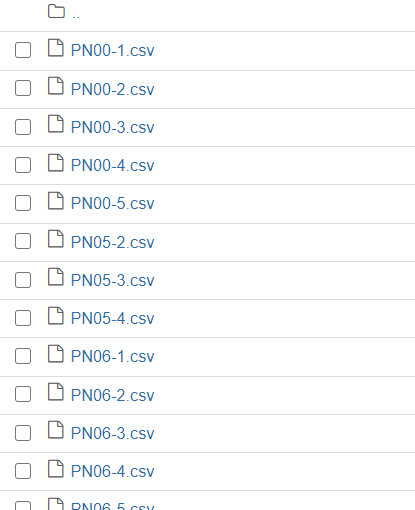
    

Now save all the files as one csv file.

In [ ]:
# Read all csv files in directory and append them to the same dataframe
import glob

path = 'data/dataset_1/freq_dom_data'
all_files = glob.glob(path + "/*.csv")
df_seizure = pd.concat((pd.read_csv(f) for f in all_files))
# peep_me()

# Store as one csv file
path = 'data/dataset_1/freq_dom_data'
df_seizure.to_csv(path + '/' + 'seizure_raw_210321.csv')

In [8]:
path = 'data/dataset_1/freq_dom_data'
df_seizure = pd.read_csv(path + '/' + 'seizure_raw_210321.csv')

# EDA

We can do some EDA on our extracted features data.

In [10]:
df_seizure.head(3)

,Unnamed: 0,Unnamed: 0.1,e_t_0_1_12_1,e_t_0_2_12_1,e_t_0_3_12_1,e_t_0_4_12_1,e_t_0_5_12_1,e_t_0_6_12_1,e_t_0_7_12_1,e_t_0_8_12_1,...,e_t_0_4_12_30.1,e_t_0_5_12_30.1,e_t_0_6_12_30.1,e_t_0_7_12_30.1,e_t_0_8_12_30.1,e_t_0_9_12_30.1,e_t_0_10_12_30.1,e_t_0_11_12_30.1,e_t_0_12_12_30.1,target
0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,1,1,1.177438e-13,1.178987e-13,1.181566e-13,1.185170e-13,1.189794e-13,1.195427e-13,1.202062e-13,1.209685e-13,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,2,2,1.905079e-13,1.907227e-13,1.910800e-13,1.915793e-13,1.922195e-13,1.929992e-13,1.939169e-13,1.949707e-13,...,3.592359e-12,3.604365e-12,3.618990e-12,3.636202e-12,3.655969e-12,3.678249e-12,3.702998e-12,3.730165e-12,3.759696e-12,0.0


The complete file has 87,201 observation and 720 features + the target.

The number is 720 = 30 channels * 12 frequency bands per channel * 2 epochs stacked together (as discussed earlier)

In [11]:
df_seizure.shape

(87201, 723)

In [43]:
# Make a copy of the df to work with
df_seizure_w = df_seizure.copy()

Check for unique labels:
- 0 is all the time before seizure
- 2 seizure time
- 1 after the seizure

These labels will be changed later as required.

In [44]:
# unique values
df_seizure_w['target'].unique()

array([0., 2., 1.])

The purpose of the next code is make seizure epoch label as 1 and every non-seizure epoch as 0.

In [45]:
# change the after seizure label from 1 to 0
df_seizure_w['target'] = np.where(df_seizure_w['target'] == 1,0, df_seizure_w['target'])
df_seizure_w['target'].unique()

array([0., 2.])

In [46]:
# change the seizure label from 2 to 1
df_seizure_w['target'] = np.where(df_seizure_w['target'] == 2,1, df_seizure_w['target'])
df_seizure_w['target'].unique()

array([0., 1.])

In [51]:
df_seizure_w['target'].value_counts()

0.0    86597
1.0      604
Name: target, dtype: int64

In [ ]:
The data seems to be very imbalanced

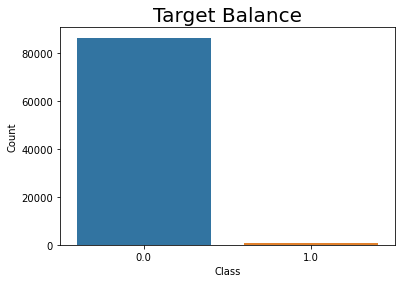

In [52]:
ax  = sns.barplot(x = df_seizure_w['target'].unique(),  y = df_seizure_w['target'].value_counts());
ax.set(xlabel='Class', ylabel='Count')
plt.title('Target Balance', size = 20);

In [53]:
one = (df_seizure_w['target'] == 1).sum()
zero = (df_seizure_w['target'] == 0).sum()
print(f'Class imbalance is {round(100 * one / (one + zero),3)} percent,')
print('This is a severe class imbalance, this will later be addressed.')

Class imbalance is 0.693 percent,
This is a severe class imbalance, this will later be addressed.


In [54]:
df_seizure_w.head(3)

,Unnamed: 0,Unnamed: 0.1,e_t_0_1_12_1,e_t_0_2_12_1,e_t_0_3_12_1,e_t_0_4_12_1,e_t_0_5_12_1,e_t_0_6_12_1,e_t_0_7_12_1,e_t_0_8_12_1,...,e_t_0_4_12_30.1,e_t_0_5_12_30.1,e_t_0_6_12_30.1,e_t_0_7_12_30.1,e_t_0_8_12_30.1,e_t_0_9_12_30.1,e_t_0_10_12_30.1,e_t_0_11_12_30.1,e_t_0_12_12_30.1,target
0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,1,1,1.177438e-13,1.178987e-13,1.181566e-13,1.185170e-13,1.189794e-13,1.195427e-13,1.202062e-13,1.209685e-13,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,2,2,1.905079e-13,1.907227e-13,1.910800e-13,1.915793e-13,1.922195e-13,1.929992e-13,1.939169e-13,1.949707e-13,...,3.592359e-12,3.604365e-12,3.618990e-12,3.636202e-12,3.655969e-12,3.678249e-12,3.702998e-12,3.730165e-12,3.759696e-12,0.0


In [55]:
# drop the Unnamed columns
df_seizure_w = df_seizure_w.loc[:, ~df_seizure_w.columns.str.contains('^Unnamed')]
df_seizure_w.head(1)

,e_t_0_1_12_1,e_t_0_2_12_1,e_t_0_3_12_1,e_t_0_4_12_1,e_t_0_5_12_1,e_t_0_6_12_1,e_t_0_7_12_1,e_t_0_8_12_1,e_t_0_9_12_1,e_t_0_10_12_1,...,e_t_0_4_12_30.1,e_t_0_5_12_30.1,e_t_0_6_12_30.1,e_t_0_7_12_30.1,e_t_0_8_12_30.1,e_t_0_9_12_30.1,e_t_0_10_12_30.1,e_t_0_11_12_30.1,e_t_0_12_12_30.1,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# data types ok?
# data type limit ok?
# all data types are float, this is OK for now.

In [56]:
df_seizure_w.dtypes

e_t_0_1_12_1        float64
e_t_0_2_12_1        float64
e_t_0_3_12_1        float64
e_t_0_4_12_1        float64
e_t_0_5_12_1        float64
                     ...   
e_t_0_9_12_30.1     float64
e_t_0_10_12_30.1    float64
e_t_0_11_12_30.1    float64
e_t_0_12_12_30.1    float64
target              float64
Length: 721, dtype: object

All data types in the dataframe are float64.

Not expected to have some , but the following will check for empty data.

In [57]:
# empty rows?
df_seizure_w.isna().sum().sum()

0

No empty rows.

In [36]:
np.where(pd.isna(df_seizure_w))

(array([], dtype=int64), array([], dtype=int64))

In [37]:
# duplicate rows?
df_seizure_w.T.duplicated().any()

False

And no duplicates.

In [58]:
# Describe the dataframe
df_seizure_w.describe().T

,count,mean,std,min,25%,50%,75%,max
e_t_0_1_12_1,87201.0,1.611830e-12,8.054716e-12,0.0,8.407285e-15,2.454430e-14,2.185111e-13,5.829067e-10
e_t_0_2_12_1,87201.0,1.613823e-12,8.065109e-12,0.0,8.416605e-15,2.456938e-14,2.187196e-13,5.839752e-10
e_t_0_3_12_1,87201.0,1.617141e-12,8.082416e-12,0.0,8.432118e-15,2.461680e-14,2.191036e-13,5.857549e-10
e_t_0_4_12_1,87201.0,1.621778e-12,8.106610e-12,0.0,8.452179e-15,2.467667e-14,2.196485e-13,5.882436e-10
e_t_0_5_12_1,87201.0,1.627726e-12,8.137658e-12,0.0,8.480585e-15,2.475999e-14,2.203901e-13,5.914387e-10
...,...,...,...,...,...,...,...,...
e_t_0_9_12_30.1,87201.0,1.689817e-12,8.318235e-12,0.0,9.372293e-15,3.437231e-14,2.630686e-13,6.090295e-10
e_t_0_10_12_30.1,87201.0,1.702325e-12,8.383435e-12,0.0,9.432804e-15,3.459534e-14,2.649072e-13,6.156404e-10
e_t_0_11_12_30.1,87201.0,1.716071e-12,8.455174e-12,0.0,9.501426e-15,3.484857e-14,2.668471e-13,6.229200e-10
e_t_0_12_12_30.1,87201.0,1.731032e-12,8.533355e-12,0.0,9.575623e-15,3.510766e-14,2.689857e-13,6.308606e-10


Th data has zero values (very few), no negative values as this is a power density.

No we store this file to disk as `seizure_w_210321.csv`, this will be the file to work with from now onward. This file contains all the data for dataset_1 where epoch = 3 and after we relabeled the target column.

In [ ]:
# Store df_seizure_w as one csv file
path = 'data/dataset_1/freq_dom_data'
df_seizure_w.to_csv(path + '/' + 'seizure_w_210321.csv')

There are too many features to plot. This exploration will be done as PCA, bur for now can look into a sample of the features.

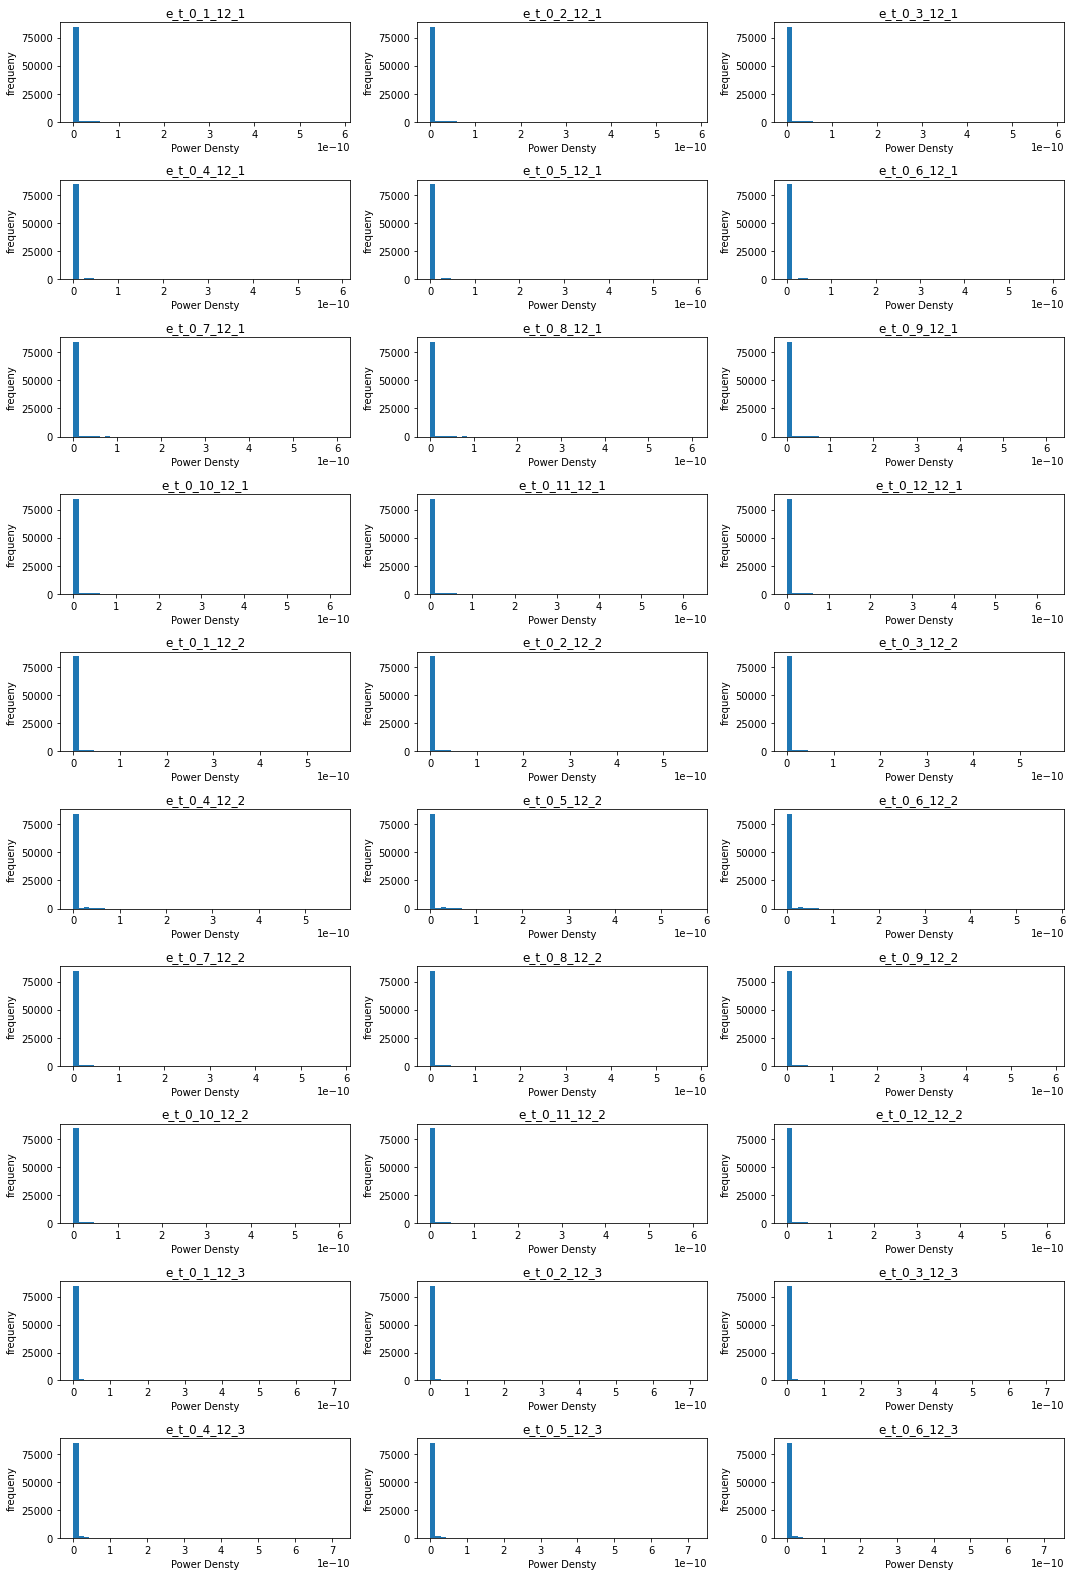

In [67]:
# Features distribution
plt.subplots(10,3, figsize=(15,22))

for i in range(30):
    plt.subplot(10,3, i+1)
    plt.hist(df_seizure_w.iloc[:,i], bins = 50)
    plt.xlabel('Power Densty')
    plt.ylabel('frequeny')
    plt.title(df_seizure_w.columns[i])
#     plt.legend()
    
plt.tight_layout()    
plt.show()

Features are skewed to the right with most of the data around Zero. This is expected as the power density is an average aggregation on the frequency bands.

The following code has is a sample of the features to how if there some separation between the classes.

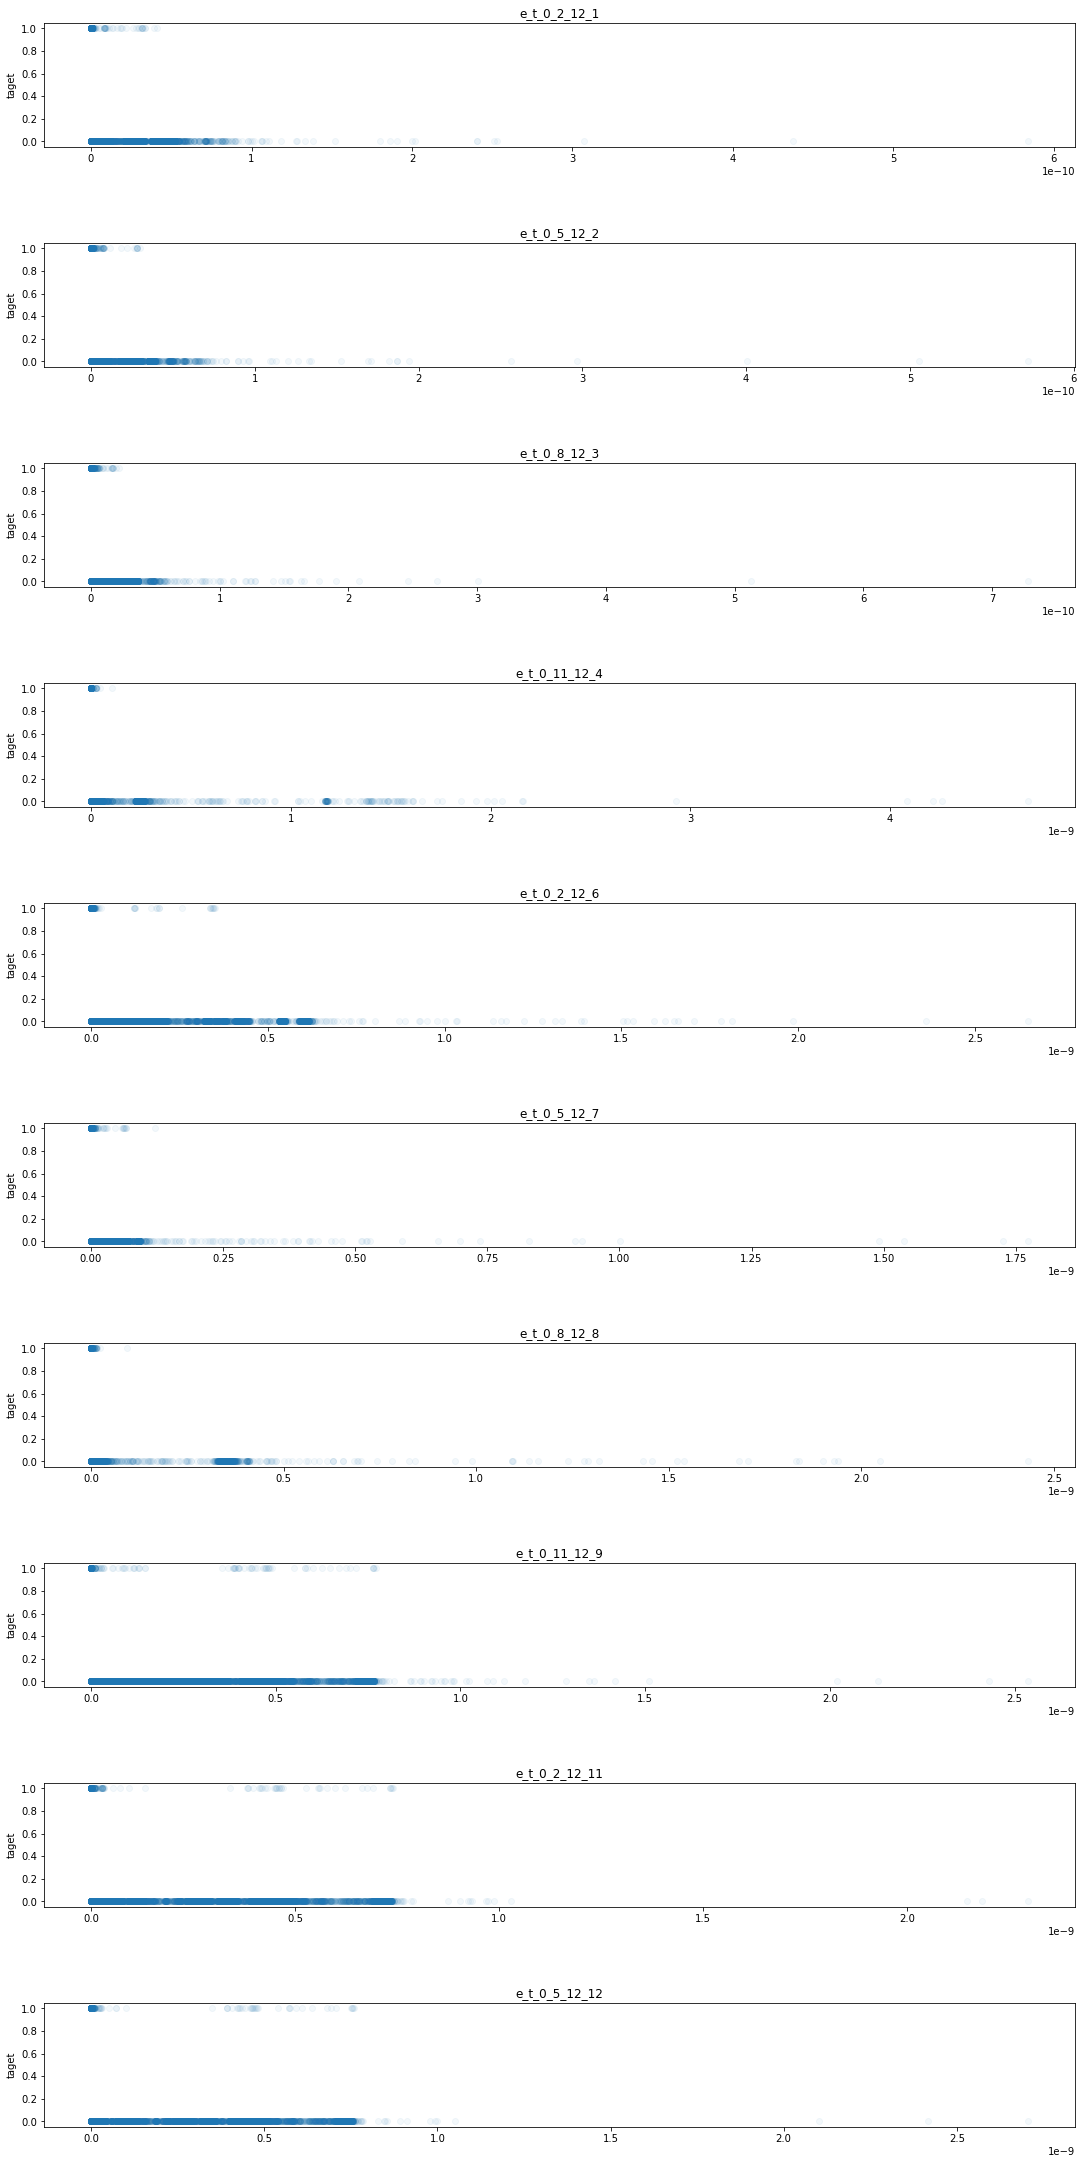

In [73]:
plt.subplots(10,1, figsize  = (15,30))

s = 1
for i in np.arange(1, 151, 15):
    plt.subplot(10,1, s)
    plt.scatter(df_seizure_w[df_seizure_w.columns[i]], df_seizure_w[df_seizure_w.columns[720]], alpha = 0.05)
    # plt.xlabel('')
    plt.ylabel('taget')
    plt.title(df_seizure_w.columns[i])
    s = s+ 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)
plt.show()

These plots indicates that if some separation between the class exist, then it is not that clear or significant. The following will use dimensionality reduction to explore the data better.

The data will first be separated into X and y.

In [ ]:
# Read the file if not in memory
# read file
path = 'data/dataset_1/freq_dom_data'
df_seizure_w = pd.read_csv(path + '/' + 'seizure_w_210321')

In [ ]:
# drop the Unnamed columns
df_seizure_w = df_seizure_w.loc[:, ~df_seizure_w.columns.str.contains('^Unnamed')]
df_seizure_w.head(1)

In [74]:
# separate x and y
X = df_seizure_w.drop('target', axis=1)
y = df_seizure_w['target']

In [75]:
X.head()

,e_t_0_1_12_1,e_t_0_2_12_1,e_t_0_3_12_1,e_t_0_4_12_1,e_t_0_5_12_1,e_t_0_6_12_1,e_t_0_7_12_1,e_t_0_8_12_1,e_t_0_9_12_1,e_t_0_10_12_1,...,e_t_0_3_12_30.1,e_t_0_4_12_30.1,e_t_0_5_12_30.1,e_t_0_6_12_30.1,e_t_0_7_12_30.1,e_t_0_8_12_30.1,e_t_0_9_12_30.1,e_t_0_10_12_30.1,e_t_0_11_12_30.1,e_t_0_12_12_30.1
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.177438e-13,1.178987e-13,1.181566e-13,1.185170e-13,1.189794e-13,1.195427e-13,1.202062e-13,1.209685e-13,1.218284e-13,1.227843e-13,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,1.905079e-13,1.907227e-13,1.910800e-13,1.915793e-13,1.922195e-13,1.929992e-13,1.939169e-13,1.949707e-13,1.961584e-13,1.974775e-13,...,3.582996e-12,3.592359e-12,3.604365e-12,3.618990e-12,3.636202e-12,3.655969e-12,3.678249e-12,3.702998e-12,3.730165e-12,3.759696e-12
3,7.293599e-14,7.301108e-14,7.313605e-14,7.331065e-14,7.353451e-14,7.380718e-14,7.412808e-14,7.449654e-14,7.491182e-14,7.537304e-14,...,1.949881e-12,1.954333e-12,1.960039e-12,1.966987e-12,1.975161e-12,1.984545e-12,1.995115e-12,2.006850e-12,2.019723e-12,2.033705e-12
4,3.163289e-14,3.166741e-14,3.172488e-14,3.180517e-14,3.190812e-14,3.203353e-14,3.218115e-14,3.235067e-14,3.254176e-14,3.275404e-14,...,1.389263e-12,1.392502e-12,1.396656e-12,1.401713e-12,1.407663e-12,1.414493e-12,1.422188e-12,1.430729e-12,1.440099e-12,1.450277e-12


In [77]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: target, dtype: float64

In [83]:
print(
    f'The features data has {X.shape[0]} rows and {X.shape[1]} columns.')
print(
    f'The target has {y.shape[0]} rows.')

The features data has 87201 rows and 720 columns.
The target has 87201 rows.


One problem that we identified earlier was the fact that the data is **severely imbalanced**, ~99% to ~1%. This is a common problem on this subject matter as per the literature. This is because the data consists of hours of recordings but only includes minutes-long seizures.

One popular technique to deal with this problem is to up-sample the minority class. There are other ways to address this issue such as down-sample the majority class or up-sample and down-sample both classes. Up-sampling is preferred over down-sampling because down-sampling reduces the data size and may delete some important patterns in the deleted observations.

Up-sample the minority class is what will be used on this project. **imblearn SMOTE** is a popular library used on similar problems and it will be used on this project.

Now, we will split the data into train and test before doing PCA.

In [79]:
# Split into train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

Then the data will be up-samled for the minority class.

In [85]:
import imblearn
print(imblearn.__version__)

0.7.0


In [86]:
import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy=0.2,
                   random_state=1)  # 20% oversampling, from 0.6%
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [87]:
print(
    f'The features data has {X_train_os.shape[0]} rows and {X_train_os.shape[1]} columns.')
print(
    f'The target has {y_train_os.shape[0]} rows.')

The features data has 83132 rows and 720 columns.
The target has 83132 rows.


In [88]:
y_train_os.value_counts()

0.0    69277
1.0    13855
Name: target, dtype: int64

The new target balance:

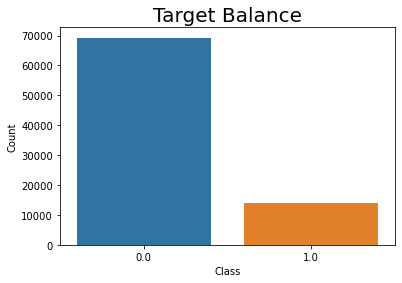

In [90]:
ax  = sns.barplot(x = y_train_os.unique(),  y = y_train_os.value_counts());
ax.set(xlabel='Class', ylabel='Count')
plt.title('Target Balance', size = 20);

Then the data will be scaled using the standard scaler.

In [91]:
# use standard scaler for the first pass
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

# scale data - train + test, first fit
standard_scaler.fit(X_train_os)
X_train_os_ss = standard_scaler.transform(X_train_os)
X_test_ss = standard_scaler.transform(X_test)

Then PCA is run.

In [93]:
# PCA first to look at the data - reduce dimensions
from sklearn.decomposition import PCA

# fit and transform
pca = PCA(n_components=X_train_os_ss.shape[1])
pca.fit(X_train_os_ss)  # _ss is scaled data
X_train_os_ss_PCA = pca.transform(X_train_os_ss)
X_test_ss_PCA = pca.transform(X_train_os_ss)

The ratio of explained variance for each component which is calculated by the variance on that component divided by the sum of all variances of all components is obtained on the array below.

In [96]:
expl_var = pca.explained_variance_ratio_
print(expl_var[:15])

[0.33070402 0.31154641 0.05553528 0.04606556 0.03308177 0.02983371
 0.02932928 0.0189507  0.0162437  0.01520572 0.01428745 0.00966575
 0.00892367 0.00888914 0.00840619]


In [117]:
print(f'The first 16 PCA dimensions provide {np.cumsum(expl_var)[15]}')

The first 16 PCA dimensions provide 0.9437754037812851


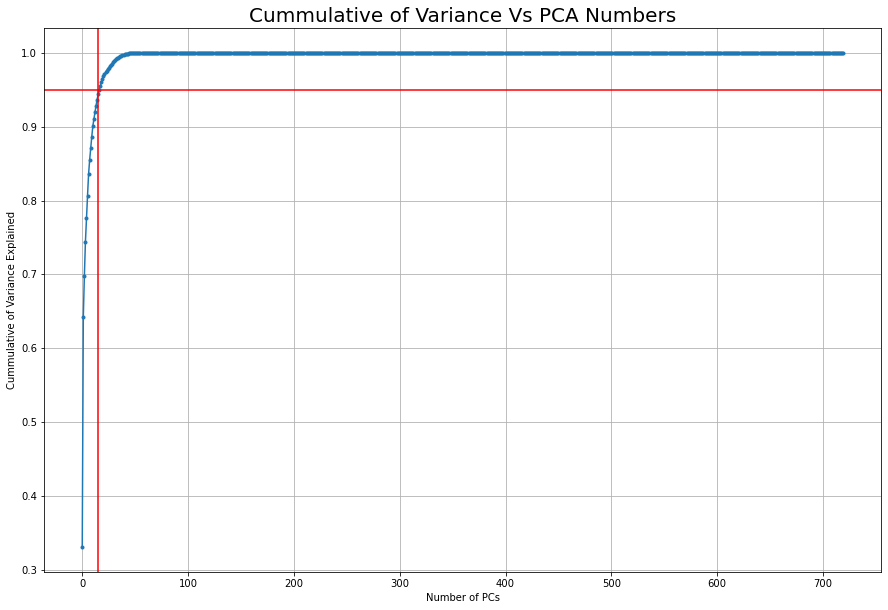

In [115]:
plt.figure(figsize=(15, 10))

plt.plot(range(0, 720), np.cumsum(expl_var), marker='.')
plt.axhline(y=0.95, c='red')  # mark 95% cum variance
plt.axvline(x=15, c='red')  # mark PCAs at 95% cum variance
plt.xlabel('Number of PCs')
plt.ylabel('Cummulative of Variance Explained')
# plt.xticks(range(0,200,100))
plt.grid()
plt.title('Cummulative of Variance Vs PCA Numbers', size=20)

plt.show()

Let us look at the first and second components.

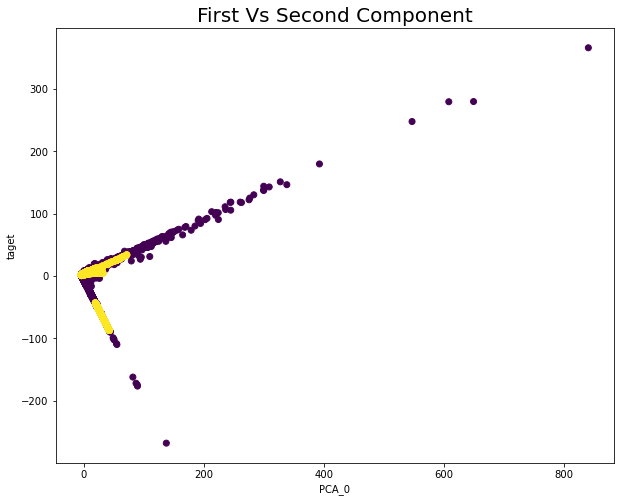

In [108]:
plt.figure(figsize  = (10,8))

plt.scatter(X_train_os_ss_PCA[:,0],X_train_os_ss_PCA[:,1], c=y_train_os)
plt.xlabel('PCA_0')
plt.ylabel('PCA_1')
plt.title('First Vs Second Component', size = 20)
plt.ylabel('taget')

plt.show()

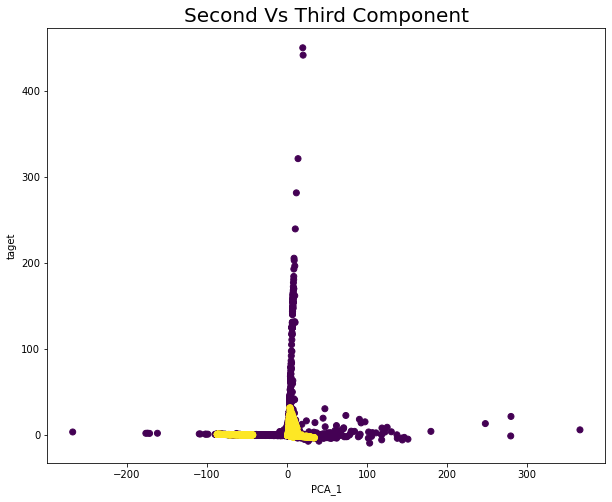

In [109]:
plt.figure(figsize  = (10,8))

plt.scatter(X_train_os_ss_PCA[:,1],X_train_os_ss_PCA[:,2], c=y_train_os)
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.title('Second Vs Third Component', size = 20)
plt.ylabel('taget')

plt.show()

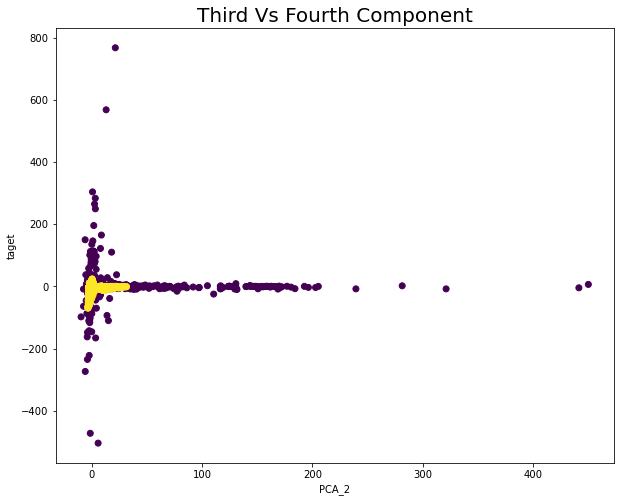

In [110]:
plt.figure(figsize  = (10,8))

plt.scatter(X_train_os_ss_PCA[:,2],X_train_os_ss_PCA[:,3], c=y_train_os)
plt.xlabel('PCA_2')
plt.ylabel('PCA_3')
plt.title('Third Vs Fourth Component', size = 20)
plt.ylabel('taget')

plt.show()

There seem to be no or very small separation on our data - at least in the first 4 components. Let us look at T-SNE, we may see some significant separation.

In [111]:
# TSNE
from sklearn.manifold import TSNE

# tSNE with two components
my_tSNE = TSNE(n_components=2)

X_tSNE = my_tSNE.fit_transform(X_train_os_ss)

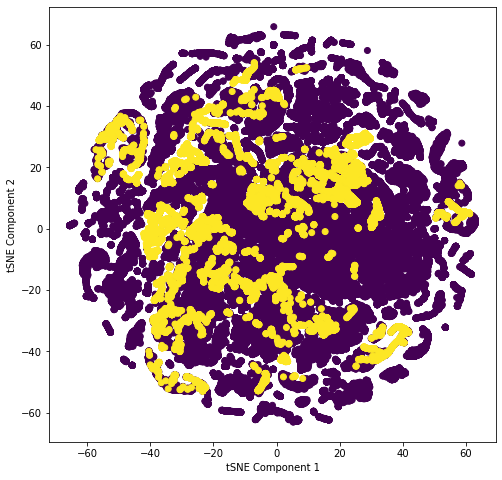

In [112]:
# Plotting the tSNE-transformed data (only the first two dimensions)
plt.figure(figsize=(8, 8))
plt.scatter(X_tSNE[:,0],X_tSNE[:,1],c=y_train_os)

plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')

plt.show()

Still, very small separation on our data if not none. This is no good news, but let us try modeling.

But before modeling we will take only the first 16 PCA's to reduce dimentionality. The first 16 PCA's account for ~95% of the data variance.

In [118]:
# extract the first 16 dimensions only
# fit and transform
pca = PCA(n_components=15)
pca.fit(X_train_os_ss) # _ss is scaled data
X_train_os_ss_PCA16 = pca.transform(X_train_os_ss)
X_test_ss_PCA16 = pca.transform(X_test_ss)

Different SMOTE percentage has been tried with little difference on results, the repeated code has been omitted.

# Initial modeling

Let us start by a simple linear classifier.

In [119]:
# instantiate and fit the logistic model
from sklearn.linear_model import LogisticRegression

# max_iteration param set to 100
log_model = LogisticRegression(solver='lbfgs', C=1, max_iter=1000)
log_model.fit(X_train_os_ss_PCA16, y_train_os)

LogisticRegression(C=1, max_iter=1000)

In [120]:
# Score the logistic regression model
print(f'The model accuracy score on the train data is {round(log_model.score(X_train_os_ss_PCA16, y_train_os),4)}.')
print(f'The model accuracy score on the test data is {round(log_model.score(X_test_ss_PCA16, y_test),4)}.')

The model accuracy score on the train data is 0.8371.
The model accuracy score on the test data is 0.9921.


In [121]:
log_model.coef_

array([[-0.06187789, -0.03501638, -0.74765406, -0.00921436,  0.49797245,
        -0.16969553, -0.65671886, -0.30624839,  0.4753488 , -0.57424083,
        -0.16458853, -0.85162223,  0.00762268,  0.74731762, -0.26302425]])

Test data accuracy 0.99 is much higher than train data 0.83, we need to look at the confusion matrix and Precision and Recall scores as the accuracies are misleading.

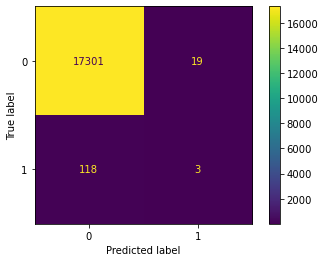

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predict, generate the confusion matrix and plot the heatmeap
y_pred = log_model.predict(X_test_ss_PCA16)

confusion_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix).plot()
plt.show()

In [123]:
print(f'Model Precision score is {round(precision_recall_f1_scores(y_test, y_pred)[0],3)}.')
print(f'Model Recall score is {round(precision_recall_f1_scores(y_test, y_pred)[1],3)}.')
print(f'Model f1-score is {round(precision_recall_f1_scores(y_test, y_pred)[2],3)}.')

Model Precision score is 0.136.
Model Recall score is 0.025.
Model f1-score is 0.042.


Very low Precision and Recall scores and high misclassification on the positive class, all have been misclassified (118) but three (3)!

The reason why the test accuracy was higher than the train accuracy is that the test data is not up-sampled and so the misclassification was insignificant in terms of quantity given the small class percentage ~0.6% while this percentage is 20% in our train data as it was up-sampled. However, Precision and Recall scores are the true measures in this scenario.

The linear model is doing a very poor job and this is expected as the classes are overlapping, a more sophisticated algorithm should be used.

Let us try fitting a dense network.

In [126]:
# Create a new sequential model
model = keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(12, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 
# model.add(layers.BatchNormalization()) 

model.add(layers.Dense(12, activation="relu", kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 
# model.add(layers.BatchNormalization())

model.add(layers.Dense(12, activation="relu", kernel_regularizer=regularizer)) 
model.add(layers.Dropout(0.1)) # Set 20% of the nodes to 0. 
# model.add(layers.BatchNormalization())

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [127]:
# Fit the model
history = model.fit(X_train_os_ss_PCA16, y_train_os, epochs=100)
peep_me()

Epoch 1/100
2598/2598 [==============================] - 3s 1ms/step - loss: 0.5043 - binary_accuracy: 0.8246
Epoch 2/100
2598/2598 [==============================] - 3s 1ms/step - loss: 0.4458 - binary_accuracy: 0.8374
Epoch 3/100
2598/2598 [==============================] - 3s 1ms/step - loss: 0.4308 - binary_accuracy: 0.8384
Epoch 4/100
2598/2598 [==============================] - 3s 1ms/step - loss: 0.4211 - binary_accuracy: 0.8391
Epoch 5/100
2598/2598 [==============================] - 3s 1ms/step - loss: 0.4097 - binary_accuracy: 0.8391
Epoch 6/100
2598/2598 [==============================] - 3s 1ms/step - loss: 0.4003 - binary_accuracy: 0.8401
Epoch 7/100
2598/2598 [==============================] - 3s 1ms/step - loss: 0.3930 - binary_accuracy: 0.8409
Epoch 8/100
2598/2598 [==============================] - 3s 1ms/step - loss: 0.3902 - binary_accuracy: 0.8407
Epoch 9/100
2598/2598 [==============================] - 3s 1ms/step - loss: 0.3864 - binary_accuracy: 0.8408
Epoch 10/1

In [128]:
# Evaluate the model using the test data and generate predictions
# Evaluate the network
train_accuracy = history.history['binary_accuracy'][-1]
result = model.evaluate(X_test_ss_PCA16,y_test, verbose=0)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {result[1]:.4f}')

predictions = model.predict(X_test_ss_PCA16)

Train Accuracy: 0.8551
Test Accuracy: 0.9651


It is clear that the neural network did not help much here. Let us attempt to use the minmax scaler instead of the standard scaler. Although no significant change is expected it is worth trying.

In [129]:
# use standard scaler for the first pass
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

# scale data - train + test, first fit
minmax_scaler.fit(X_train_os)
X_train_os_ms = minmax_scaler.transform(X_train_os)
X_test_ms = minmax_scaler.transform(X_test)

In [132]:
# PCA first to look at the data - reduce dimensions
# fit and transform
pca = PCA(n_components=X_train_os_ms.shape[1])
pca.fit(X_train_os_ms)  # _ms is scaled data - minmaxscaler
X_train_os_ms_PCA = pca.transform(X_train_os_ms)
X_test_ms_PCA = pca.transform(X_test_ms)

In [134]:
expl_var = pca.explained_variance_ratio_
print(expl_var[:15])

[0.77001525 0.11249633 0.03442556 0.01363031 0.00938577 0.00802111
 0.00775888 0.00698278 0.00435507 0.0039162  0.00297228 0.0027521
 0.00213132 0.00202021 0.00192664]


In [135]:
print(f'The first 6 PCA dimensions provide {np.cumsum(expl_var)[5]}')

The first 6 PCA dimensions provide 0.9479743364230506


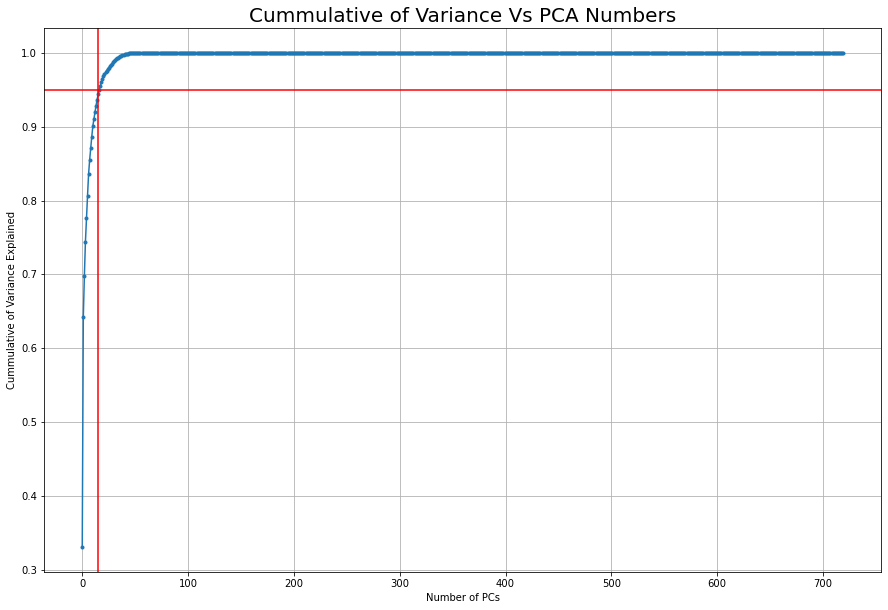

In [133]:
plt.figure(figsize=(15, 10))

plt.plot(range(0, 720), np.cumsum(expl_var), marker='.')
plt.axhline(y=0.95, c='red')  # mark 95% cum variance
plt.axvline(x=15, c='red')  # mark PCAs at 95% cum variance
plt.xlabel('Number of PCs')
plt.ylabel('Cummulative of Variance Explained')
# plt.xticks(range(0,200,100))
plt.grid()
plt.title('Cummulative of Variance Vs PCA Numbers', size=20)

plt.show()

minmax scaler seem to use less dimensions for the same variance compared to the standard scaler, but the standard scaler is still faster to fit and transform.

Let us look at the first and second components.

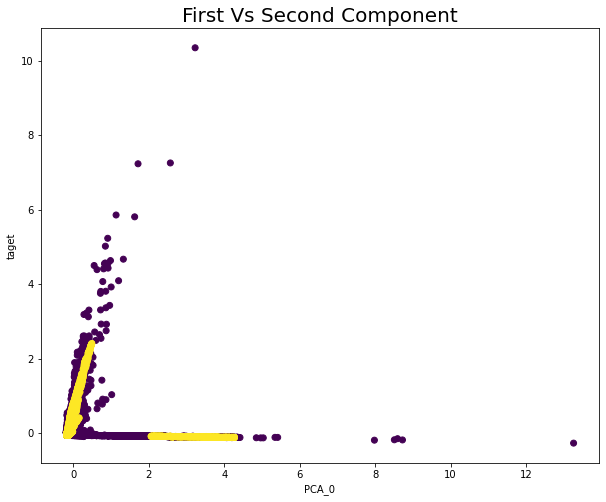

In [137]:
plt.figure(figsize  = (10,8))

plt.scatter(X_train_os_ms_PCA[:,0],X_train_os_ms_PCA[:,1], c=y_train_os)
plt.xlabel('PCA_0')
plt.ylabel('PCA_1')
plt.title('First Vs Second Component', size = 20)
plt.ylabel('taget')

plt.show()

The same class overlapping issue is exits. Minmax scaler is not resulting in any significant change.

The minmax scaler was used to fit a logistic model and a neural network model but the results were no difference than the standard scaler models. The code is omitted is not included on this notebook.

As a recap:
so far:
- PCA plots show big overlap between the two classes
- Low Recall 0-5%
- High Test score but low Train score
- Big misclassification on the confusion matrix
- Two algorithms have been used, results are not good

It is likely that there is an issue on my feature extraction process, either:
1 - the method used is not resulting in any differentiating features, or
2 - the method is OK, but there is an issue in the code execution,

OR MAYBE SOMETHING ELSE?!

I will start by the most likely cause ie #2

The code has been check and nothing wrong has been found, the feature extraction function is doing what it is supposed to do.

Also, the literature has been consulted and it has been confirmed that the method used on features extraction is a good method, so where is the problem coming from?

The next step done was to change the `epoch` size from 3 seconds and try: 6 seconds, 1 second and 0.25 second. Upon plotting and checking the PCA first components, it was found that in fact the 3 second epoch is better. this code is omitted for brevity.

Again, a deadlock!

At this stage I decided to try a different way of extracting my features, that is to extract the statistical features of the epoch instead of their frequency domain representation. These features are: the mean, the min and the max for each epoch for each channel.
I built a function similar to the `time_to_frequency_domain` but extracts the statistical features (mean, max and min), then I went through the same steps of SMOTE, scaling, PCA and initial modeling, but the results were not better. 

The code for this attempt has been omitted and not included on this notebook.

Then I decided to try with my second dataset, dataset_2.

# Features extraction - Dataset_2 

In [140]:
dataset_path = 'data/dataset_2'

In [142]:
# Read csv file containig the database annotations and store into dataframe
df_seizures_record = pd.read_csv(
    dataset_path + '/' + 'ds2_seizures_record.csv', index_col='Index')
df_seizures_record.head(3)

,Patient,File_name,Seizure_n,Samp_rate_Hz,Registration_start_time,Registration_end_time,Seizure_start_time,Seizure_end_time,Remarks
Index,,,,,,,,,
0,chb01,chb01_03.edf,1,256,13:43:04,14:43:04,2996,3036,NaN
1,chb01,chb01_04.edf,2,256,14:43:12,15:43:12,1467,1494,NaN
2,chb01,chb01_15.edf,3,256,1:44:44,2:44:44,1732,1772,NaN


In [143]:
# Delete Nan from DataFrame
df_seizures_record = df_seizures_record[~df_seizures_record['Patient'].isna()]

In [144]:
df_seizures_record.info()     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Patient                  84 non-null     object
 1   File_name                84 non-null     object
 2   Seizure_n                84 non-null     int64 
 3   Samp_rate_Hz             84 non-null     int64 
 4   Registration_start_time  84 non-null     object
 5   Registration_end_time    84 non-null     object
 6   Seizure_start_time       84 non-null     int64 
 7   Seizure_end_time         84 non-null     int64 
 8   Remarks                  21 non-null     object
dtypes: int64(4), object(5)
memory usage: 6.6+ KB


In [146]:
def normalize_time_s(es_t):
    import datetime

    '''
    This function changes es_t time from H:M:S format to S format

    '''
            
    h, m, s = es_t.split(':') # used ':' instead of '.' as in dataset_1
    t_in_sec  = int(h) * 3600 + int(m) * 60 + int(s)
    
    return  t_in_sec   

In [147]:
df_seizures_record['Registration_start_time'] = df_seizures_record['Registration_start_time'].apply(normalize_time_s)
df_seizures_record['Registration_end_time'] = df_seizures_record['Registration_end_time'].apply(normalize_time_s)

In [148]:
df_seizures_record.head(2)

,Patient,File_name,Seizure_n,Samp_rate_Hz,Registration_start_time,Registration_end_time,Seizure_start_time,Seizure_end_time,Remarks
Index,,,,,,,,,
0,chb01,chb01_03.edf,1,256,49384,52984,2996,3036,NaN
1,chb01,chb01_04.edf,2,256,52992,56592,1467,1494,NaN


In [149]:
df_seizures_record['n_Registration_start_time'] = df_seizures_record['Registration_start_time'] - \
    df_seizures_record['Registration_start_time']
df_seizures_record['n_Registration_end_time'] = df_seizures_record['Registration_end_time'] - \
    df_seizures_record['Registration_start_time']
df_seizures_record['n_Seizure_start_time'] = df_seizures_record['Seizure_start_time']
df_seizures_record['n_Seizure_end_time'] = df_seizures_record['Seizure_end_time']

df_seizures_record['Seizure_t'] = df_seizures_record['n_Seizure_end_time'] - \
    df_seizures_record['n_Seizure_start_time']

df_seizures_record['pre_s_t'] = df_seizures_record['n_Seizure_start_time'] - \
    df_seizures_record['n_Registration_start_time']
df_seizures_record['post_s_t'] = df_seizures_record['n_Registration_end_time'] - \
    df_seizures_record['n_Seizure_end_time']

In [151]:
df_seizures_record.head(2)

,Patient,File_name,Seizure_n,Samp_rate_Hz,Registration_start_time,Registration_end_time,Seizure_start_time,Seizure_end_time,Remarks,n_Registration_start_time,n_Registration_end_time,n_Seizure_start_time,n_Seizure_end_time,Seizure_t,pre_s_t,post_s_t
Index,,,,,,,,,,,,,,,,
0,chb01,chb01_03.edf,1,256,49384,52984,2996,3036,NaN,0,3600,2996,3036,40,2996,564
1,chb01,chb01_04.edf,2,256,52992,56592,1467,1494,NaN,0,3600,1467,1494,27,1467,2106


In [152]:
df_seizures_record.shape

(84, 16)

In [ ]:
# write df_seizures_record to csv file
df_seizures_record.to_csv('data/dataset_2/ds2_seizures_record_updated.csv')

First try to transform one file and plot it to see if this some separation between classes.

In [ ]:
file_path_ = 'data/dataset_2/chb01'
file_name_ = 'chb01_03.edf'
file_index_ = 0
csv_file_ = 'data/dataset_2/freq_dom_nbc_data_3s/chb01_03.csv'
seizures_record_file_ = 'data/dataset_2/ds2_seizures_record_updated.csv'
ds_ = 2
t_epoch_ = 3

df_time_3 = time_to_frequency_domain(
    file_path_, file_name_, file_index_, csv_file_, seizures_record_file_, ds_, t_epoch_)  # x min wall time

**The product of these transformations is a file with 1150 features + the target. 1150 is a product of (23 channels * 25 frequency bands * 2 adjacent epochs)**

In [153]:
# read file
path = 'data/dataset_2/freq_dom_nbc_data_3s/chb01'
# df = df_time_3
df = pd.read_csv(path + '/' + 'chb01_03.csv')
df = df.drop(df.columns[0], axis=1)
# change label 2 to lable 0
df.rename(columns = {'1150':'target'}, inplace = True)
# df.columns.values['1150'] = 'target'
df['target'] = np.where(df['target'] == 1, 0, df['target'])
# change label 2 to lable 1
df['target'] = np.where(df['target'] > 1, 1, df['target'])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,7.069850e-14,7.077120e-14,7.089218e-14,7.106119e-14,7.127784e-14,7.154167e-14,7.185210e-14,7.220844e-14,7.260991e-14,7.305563e-14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,5.036653e-14,5.041897e-14,5.050624e-14,5.062815e-14,5.078444e-14,5.097476e-14,5.119871e-14,5.145580e-14,5.174547e-14,5.206709e-14,...,4.120198e-14,4.158553e-14,4.198528e-14,4.240036e-14,4.282981e-14,4.327270e-14,4.372803e-14,4.419478e-14,4.467191e-14,0.0
3,1.329780e-13,1.331164e-13,1.333468e-13,1.336686e-13,1.340812e-13,1.345835e-13,1.351746e-13,1.358530e-13,1.366172e-13,1.374657e-13,...,3.994988e-14,4.032027e-14,4.070628e-14,4.110703e-14,4.152162e-14,4.194912e-14,4.238857e-14,4.283898e-14,4.329934e-14,0.0
4,1.464056e-13,1.465404e-13,1.467646e-13,1.470777e-13,1.474790e-13,1.479675e-13,1.485421e-13,1.492015e-13,1.499440e-13,1.507679e-13,...,7.171705e-14,7.235416e-14,7.301771e-14,7.370615e-14,7.441785e-14,7.515114e-14,7.590431e-14,7.667558e-14,7.746314e-14,0.0


Check the target distribution.

In [155]:
df['target'].value_counts()

0.0    1183
1.0      12
Name: target, dtype: int64

Now, plot every adjacent columns to see if this some separation between classes (for sample columns). 

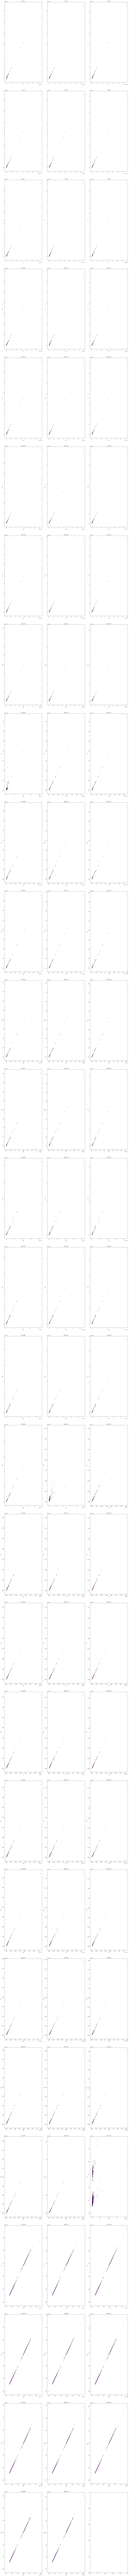

In [157]:
plt.subplots(29, 3, figsize=(20, 400))

s = 1
for i in np.arange(0, 86, 1):
    plt.subplot(29, 3, s)
    plt.scatter(df[df.columns[i]], df[df.columns[i+1]],
                c=df['target'],  marker='.')
    plt.xlabel(df.columns[i])
    plt.ylabel(df.columns[i+1])
    plt.title(df.columns[i] + ' & ' + df.columns[i+1])
    s = s + 1

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)
plt.show()

Looking at the plots, it seems there is a clear separation between the two classes, the one in the dark color and the one in yellow.

I have decided here to only transform part of dataset_2 and fit an initial model instead of transforming the whole dataset and then modeling. I chose to use patient 'chb01' data.

In [ ]:
# A for loop to convert all edf files for patient chb01 to PSD then store all files as csv
# 3 sec epochs

seizures_record_file_ = 'data/dataset_2/ds2_seizures_record_updated.csv'
df_seizures_record = pd.read_csv(seizures_record_file_)

# i_range = df_seizures_record['Seizure_n'].max()

for i in np.arange(0, 8): # change the start of the loop accordingly, 8 as this is patient chb01 only (7 records)
    try:

        file_path_ = 'data/dataset_2/' + df_seizures_record.loc[i,'Patient']
        file_name_ = df_seizures_record.loc[i,'File_name']
        file_index_ = i
        csv_file_ = 'data/dataset_2/freq_dom_nbc_data_3s/' + 'Patient' + \
            file_name_.split('.')[0] + '.csv'
        ds_ = 2
        t_epoch_ = 3

        time_to_frequency_domain(
            file_path_, file_name_, file_index_, csv_file_, seizures_record_file_, ds_, t_epoch_)  # x min wall time

    except:
        peep_me()
        peep_me()
        print(f'Error on file {file_name_}...............................................................')
        pass
    else:
        continue

The files are created in the `data/dataset_2/freq_dom_nbc_data_3s/` directory.

# Initial modeling - Dataset 2

This code will read all data for patient chb01 and concatenate them into one file, then relabel the data and save the resulting file as csv file.  

In [159]:
# Read all csv files in directory and append them to the same dataframe
import glob

path = 'data/dataset_2/freq_dom_nbc_data_3s/chb01'
all_files = glob.glob(path + "/*.csv")
df_seizure = pd.concat((pd.read_csv(f) for f in all_files))
peep_me()

In [160]:
# Store as one csv file
path = 'data/dataset_2/freq_dom_nbc_data_3s/chb01/combined'
df_seizure.to_csv(path + '/' + 'seizure_raw_ds2_3s_280321_chb01.csv')

df_seizure.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150
0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,1,7.069850e-14,7.077120e-14,7.089218e-14,7.106119e-14,7.127784e-14,7.154167e-14,7.185210e-14,7.220844e-14,7.260991e-14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,2,5.036653e-14,5.041897e-14,5.050624e-14,5.062815e-14,5.078444e-14,5.097476e-14,5.119871e-14,5.145580e-14,5.174547e-14,...,4.120198e-14,4.158553e-14,4.198528e-14,4.240036e-14,4.282981e-14,4.327270e-14,4.372803e-14,4.419478e-14,4.467191e-14,0.0
3,3,1.329780e-13,1.331164e-13,1.333468e-13,1.336686e-13,1.340812e-13,1.345835e-13,1.351746e-13,1.358530e-13,1.366172e-13,...,3.994988e-14,4.032027e-14,4.070628e-14,4.110703e-14,4.152162e-14,4.194912e-14,4.238857e-14,4.283898e-14,4.329934e-14,0.0
4,4,1.464056e-13,1.465404e-13,1.467646e-13,1.470777e-13,1.474790e-13,1.479675e-13,1.485421e-13,1.492015e-13,1.499440e-13,...,7.171705e-14,7.235416e-14,7.301771e-14,7.370615e-14,7.441785e-14,7.515114e-14,7.590431e-14,7.667558e-14,7.746314e-14,0.0


In [161]:
# Delete the unamed column
df_seizure = df_seizure.drop(df_seizure.columns[0], axis=1)

# Rename target column
df_seizure.rename(columns = {'1150':'target'}, inplace = True)

df_seizure.head()

,0,1,2,3,4,5,6,7,8,9,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,7.069850e-14,7.077120e-14,7.089218e-14,7.106119e-14,7.127784e-14,7.154167e-14,7.185210e-14,7.220844e-14,7.260991e-14,7.305563e-14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,5.036653e-14,5.041897e-14,5.050624e-14,5.062815e-14,5.078444e-14,5.097476e-14,5.119871e-14,5.145580e-14,5.174547e-14,5.206709e-14,...,4.120198e-14,4.158553e-14,4.198528e-14,4.240036e-14,4.282981e-14,4.327270e-14,4.372803e-14,4.419478e-14,4.467191e-14,0.0
3,1.329780e-13,1.331164e-13,1.333468e-13,1.336686e-13,1.340812e-13,1.345835e-13,1.351746e-13,1.358530e-13,1.366172e-13,1.374657e-13,...,3.994988e-14,4.032027e-14,4.070628e-14,4.110703e-14,4.152162e-14,4.194912e-14,4.238857e-14,4.283898e-14,4.329934e-14,0.0
4,1.464056e-13,1.465404e-13,1.467646e-13,1.470777e-13,1.474790e-13,1.479675e-13,1.485421e-13,1.492015e-13,1.499440e-13,1.507679e-13,...,7.171705e-14,7.235416e-14,7.301771e-14,7.370615e-14,7.441785e-14,7.515114e-14,7.590431e-14,7.667558e-14,7.746314e-14,0.0


In [162]:
print(df_seizure.shape)

(7941, 1151)


In [163]:
# Make a copy of the df to work with
df_seizure_w = df_seizure.copy()

In [164]:
# Get file unique values
df_seizure_w['target'].unique()

array([0., 2., 1.])

In [165]:
# Change the after seizure label from 1 to 0
df_seizure_w['target'] = np.where(df_seizure_w['target'] == 1,0, df_seizure_w['target'])

# Change the seizure label from 2 to 1
df_seizure_w['target'] = np.where(df_seizure_w['target'] == 2,1, df_seizure_w['target'])
df_seizure_w['target'].value_counts()

0.0    7802
1.0     139
Name: target, dtype: int64

Get the target imbalance.

In [168]:
one = (df_seizure_w['target'] == 1).sum()
zero = (df_seizure_w['target'] == 0).sum()
print(f'Class imbalance is {round(100 * one / (one + zero), 3)} percent,')
print('This is a severe class imbalance, this will later be addressed.')

Class imbalance is 1.75 percent,
This is a severe class imbalance, this will later be addressed.


In [169]:
# info
df_seizure_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7941 entries, 0 to 768
Columns: 1151 entries, 0 to target
dtypes: float64(1151)
memory usage: 69.8 MB


Check for Null and duplicates.

In [170]:
# empty rows?
df_seizure_w.isna().sum().sum()

0

In [171]:
np.where(pd.isna(df_seizure_w))

(array([], dtype=int64), array([], dtype=int64))

In [172]:
# duplicate rows?
df_seizure_w.T.duplicated().any()

True

In [173]:
df_seizure_w.describe().T

,count,mean,std,min,25%,50%,75%,max
0,7941.0,1.412964e-13,4.392105e-13,0.0,4.054095e-14,6.443002e-14,1.005942e-13,1.056814e-11
1,7941.0,1.414565e-13,4.397522e-13,0.0,4.058883e-14,6.448902e-14,1.006894e-13,1.057870e-11
2,7941.0,1.417230e-13,4.406540e-13,0.0,4.065920e-14,6.458800e-14,1.008477e-13,1.059629e-11
3,7941.0,1.420955e-13,4.419146e-13,0.0,4.077122e-14,6.473669e-14,1.011171e-13,1.062087e-11
4,7941.0,1.425731e-13,4.435319e-13,0.0,4.089976e-14,6.492729e-14,1.014113e-13,1.065238e-11
...,...,...,...,...,...,...,...,...
1146,7941.0,2.186303e-13,9.335472e-13,0.0,4.337642e-14,5.972328e-14,9.715505e-14,2.346960e-11
1147,7941.0,2.215283e-13,9.468182e-13,0.0,4.385121e-14,6.039216e-14,9.812980e-14,2.378349e-11
1148,7941.0,2.245140e-13,9.605133e-13,0.0,4.432584e-14,6.106106e-14,9.915669e-14,2.410702e-11
1149,7941.0,2.275823e-13,9.746126e-13,0.0,4.482021e-14,6.178527e-14,1.002882e-13,2.443967e-11


In [174]:
# store df_seizure_w as one csv file
path = 'data/dataset_2/freq_dom_nbc_data_3s/chb01/combined'
df_seizure_w.to_csv(path + '/' + 'seizure_w_ds2_3s_280321_chb01.csv')

Now let us model this patient data.

Separate X&y

In [176]:
# separate x and y
X = df_seizure_w.drop('target', axis=1)
y = df_seizure_w['target']

print(X.shape)
print(y.shape)

(7941, 1150)
(7941,)


In [177]:
X.head(1)

,0,1,2,3,4,5,6,7,8,9,...,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
X = X.drop(X.columns[0], axis = 1)
X.head(1)

,1,2,3,4,5,6,7,8,9,10,...,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
y.head(1)

0    0.0
Name: target, dtype: float64

Split into Train and Test

In [180]:
# split into train test before SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

print(X_train.shape)
print(y_train.shape)

(6352, 1149)
(6352,)


SMOTE

In [181]:
# transform the dataset

import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy=0.3, random_state = 1)  # 30% oversampling, from 1.8%
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

print(X_train_os.shape)
print(y_train_os.shape)

(8113, 1149)
(8113,)


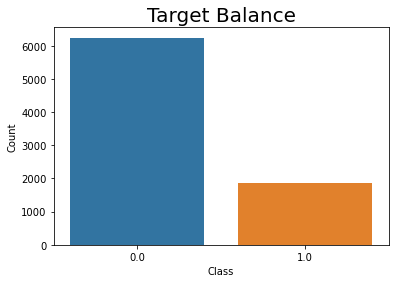

In [183]:
# plot distribution
ax  = sns.barplot(x = y_train_os.unique(),  y = y_train_os.value_counts());
ax.set(xlabel='Class', ylabel='Count')
plt.title('Target Balance', size = 20);

Scale

In [184]:
# use standard scaler for the first pass
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

# scale data - train + test, first fit
standard_scaler.fit(X_train_os)
X_train_os_ss = standard_scaler.transform(X_train_os)
X_test_ss = standard_scaler.transform(X_test)

PCA

In [185]:
# PCA first to look at the data - reduce dimensions
from sklearn.decomposition import PCA

# fit and transform
pca = PCA(n_components=X_train_os_ss.shape[1])
pca.fit(X_train_os_ss)  # _ss is scaled data
X_train_os_ss_PCA = pca.transform(X_train_os_ss)
X_test_ss_PCA = pca.transform(X_test_ss)

In [186]:
expl_var = pca.explained_variance_ratio_
print(expl_var[15])

0.0030872669952177268


In [195]:
print(f'The first 10 PCA dimensions provide {np.cumsum(expl_var)[9]}')

The first 10 PCA dimensions provide 0.9479893997570968


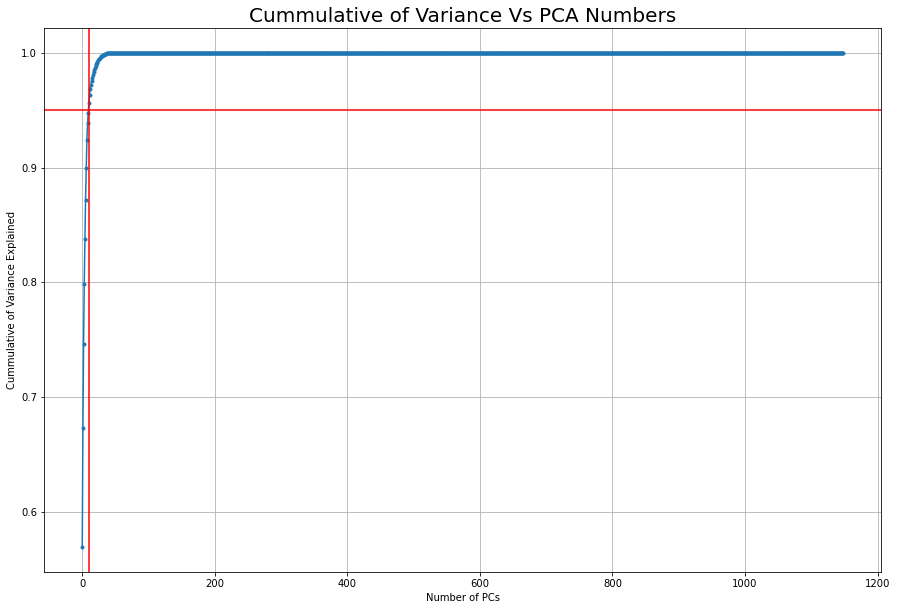

In [196]:
plt.figure(figsize=(15, 10))

plt.plot(range(0, 1149), np.cumsum(expl_var), marker='.')
plt.axhline(y=0.95, c='red')  # mark 95% cum variance
plt.axvline(x=10, c='red')  # mark PCAs at 95% cum variance
plt.xlabel('Number of PCs')
plt.ylabel('Cummulative of Variance Explained')
# plt.xticks(range(0,200,100))
plt.grid()
plt.title('Cummulative of Variance Vs PCA Numbers', size=20)

plt.show()

Let us look at the first and second components.

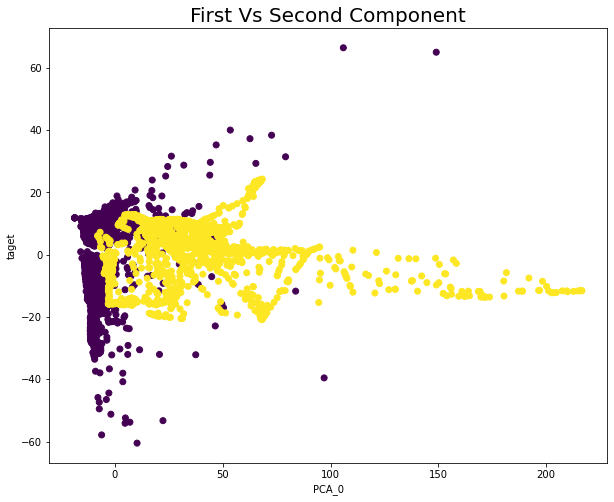

In [198]:
plt.figure(figsize  = (10,8))

plt.scatter(X_train_os_ss_PCA[:,0],X_train_os_ss_PCA[:,1], c=y_train_os)
plt.xlabel('PCA_0')
plt.ylabel('PCA_1')
plt.title('First Vs Second Component', size = 20)
plt.ylabel('taget')

plt.show()

Great, there appear to be clear separation with some overlap.

In [199]:
# extract the first 11 dimensions only, we will call it PCA_10 while it should be called PCA_11
# fit and transform
pca = PCA(n_components=10)
pca.fit(X_train_os_ss) # _ss is scaled data
X_train_os_ss_PCA10 = pca.transform(X_train_os_ss)
X_test_ss_PCA10 = pca.transform(X_test_ss)

Now model a Log Regression.

In [ ]:
# Logistic regression

In [200]:
# instantiate and fit the logistic model
from sklearn.linear_model import LogisticRegression

# max_iteration param set to 100
log_model = LogisticRegression(solver='lbfgs', C=1, max_iter=1000)
log_model.fit(X_train_os_ss_PCA10, y_train_os)

# Score the logistic regression model
print(f'The model accuracy score on the train data is {round(log_model.score(X_train_os_ss_PCA10, y_train_os),4)}.')
print(f'The model accuracy score on the test data is {round(log_model.score(X_test_ss_PCA10, y_test),4)}.')

The model accuracy score on the train data is 0.9485.
The model accuracy score on the test data is 0.983.


In [201]:
log_model.coef_

array([[ 0.17169257, -0.05695226, -0.07313073,  0.13074568,  0.06289504,
        -0.12765143, -0.18979949, -0.04151891,  0.00664715,  0.07523058]])

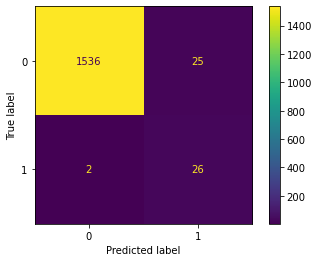

In [202]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predict, generate the confusion matrix and plot the heatmeap
y_pred = log_model.predict(X_test_ss_PCA10)

confusion_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix).plot()
plt.show()

In [203]:
print(f'Model Precision score is {round(precision_recall_f1_scores(y_test, y_pred)[0],3)}.')
print(f'Model Recall score is {round(precision_recall_f1_scores(y_test, y_pred)[1],3)}.')
print(f'Model f1-score is {round(precision_recall_f1_scores(y_test, y_pred)[2],3)}.')

Model Precision score is 0.51.
Model Recall score is 0.929.
Model f1-score is 0.658.


Great initial results, Recall is 0.9 and Precision is 0.5, and the misclassification is relatively low.

Now we can transform the whole of dataset_2 before continuing modeling.

In [ ]:
# A for loop to convert all edf files except for patient chb01 - as it was transformed earlier
# 3 sec epochs

seizures_record_file_ = 'data/dataset_2/ds2_seizures_record_updated.csv'
df_seizures_record = pd.read_csv(seizures_record_file_)

i_range = df_seizures_record['Seizure_n'].max()

for i in np.arange(8, i_range): # change the start of the loop accordingly
    try:

        file_path_ = 'data/dataset_2/' + df_seizures_record.loc[i,'Patient']
        file_name_ = df_seizures_record.loc[i,'File_name']
        file_index_ = i
        csv_file_ = 'data/dataset_2/freq_dom_nbc_data_3s/' + 'Patient' + \
            file_name_.split('.')[0] + '.csv'
        ds_ = 2
        t_epoch_ = 3

        time_to_frequency_domain(
            file_path_, file_name_, file_index_, csv_file_, seizures_record_file_, ds_, t_epoch_)  # x min wall time

    except:
        peep_me()
        peep_me()
        print(f'Error on file {file_name_}...............................................................')
        pass
    else:
        continue

77 more (in addition to patient chb01 files) files were attempted for transformation, every file corresponds to one seizure instance. There were few files that failed transformation, probably around 10 files.

Now that all files have been transformed into frequency domain, will repeat the modeling steps but for all data.

In [204]:
# read all csv files in directory and append them to the same dataframe
import glob

path = 'data/dataset_2/freq_dom_nbc_data_3s'
all_files = glob.glob(path + "/*.csv")
df_seizure = pd.concat((pd.read_csv(f) for f in all_files))
peep_me()

In [ ]:
# Store as one csv file
path = 'data/dataset_2/combined_files'
df_seizure.to_csv(path + '/' + 'seizure_raw_ds2_3s_280321_full.csv') # full dataset (missing files aborted on error ~ 10 files)
peep_me()

df_seizure.head()

In [205]:
# delete the unnamed column
df_seizure = df_seizure.drop(df_seizure.columns[0], axis=1)

# Rename target column
df_seizure.rename(columns = {'1150':'target'}, inplace = True)

df_seizure.head()

,0,1,2,3,4,5,6,7,8,9,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,7.069850e-14,7.077120e-14,7.089218e-14,7.106119e-14,7.127784e-14,7.154167e-14,7.185210e-14,7.220844e-14,7.260991e-14,7.305563e-14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,5.036653e-14,5.041897e-14,5.050624e-14,5.062815e-14,5.078444e-14,5.097476e-14,5.119871e-14,5.145580e-14,5.174547e-14,5.206709e-14,...,4.120198e-14,4.158553e-14,4.198528e-14,4.240036e-14,4.282981e-14,4.327270e-14,4.372803e-14,4.419478e-14,4.467191e-14,0.0
3,1.329780e-13,1.331164e-13,1.333468e-13,1.336686e-13,1.340812e-13,1.345835e-13,1.351746e-13,1.358530e-13,1.366172e-13,1.374657e-13,...,3.994988e-14,4.032027e-14,4.070628e-14,4.110703e-14,4.152162e-14,4.194912e-14,4.238857e-14,4.283898e-14,4.329934e-14,0.0
4,1.464056e-13,1.465404e-13,1.467646e-13,1.470777e-13,1.474790e-13,1.479675e-13,1.485421e-13,1.492015e-13,1.499440e-13,1.507679e-13,...,7.171705e-14,7.235416e-14,7.301771e-14,7.370615e-14,7.441785e-14,7.515114e-14,7.590431e-14,7.667558e-14,7.746314e-14,0.0


In [206]:
print(df_seizure.shape)

(97312, 1151)


In [208]:
# Make a copy of the df to work with
df_seizure_w = df_seizure.copy()

In [209]:
# Check nique values
df_seizure_w['target'].unique()

array([0., 2., 1.])

In [210]:
df_seizure_w['target'].value_counts()

0.0    55784
1.0    40494
2.0     1034
Name: target, dtype: int64

In [211]:
# change the after-seizure label from 1 to 0
df_seizure_w['target'] = np.where(df_seizure_w['target'] == 1,0, df_seizure_w['target'])

# change the seizure label from 2 to 1
df_seizure_w['target'] = np.where(df_seizure_w['target'] == 2,1, df_seizure_w['target'])
df_seizure_w['target'].value_counts()

0.0    96278
1.0     1034
Name: target, dtype: int64

In [212]:
# Check the imbalance
one = (df_seizure_w['target'] == 1).sum()
zero = (df_seizure_w['target'] == 0).sum()
print(f'Class imbalance is {100 * one / (one + zero)} percent,')
print('This is a severe class imbalance, this will later be addressed.')

Class imbalance is 1.062561657349556 percent,
This is a severe class imbalance, this will later be addressed.


In [213]:
# info
df_seizure_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97312 entries, 0 to 993
Columns: 1151 entries, 0 to target
dtypes: float64(1151)
memory usage: 855.3 MB


In [214]:
# empty rows?
df_seizure_w.isna().sum().sum()

0

In [215]:
# Any Null?
np.where(pd.isna(df_seizure_w))

(array([], dtype=int64), array([], dtype=int64))

In [216]:
# Any duplicate rows?
df_seizure_w.T.duplicated().any()

False

In [217]:
df_seizure_w.describe().T

,count,mean,std,min,25%,50%,75%,max
0,97312.0,1.588374e-12,1.383504e-11,0.0,4.350283e-14,1.014218e-13,3.410222e-13,1.938046e-10
1,97312.0,1.590329e-12,1.385232e-11,0.0,4.354888e-14,1.015217e-13,3.413722e-13,1.940512e-10
2,97312.0,1.593582e-12,1.388109e-11,0.0,4.362431e-14,1.017057e-13,3.419940e-13,1.944616e-10
3,97312.0,1.598128e-12,1.392130e-11,0.0,4.373034e-14,1.019352e-13,3.429846e-13,1.950352e-10
4,97312.0,1.603961e-12,1.397288e-11,0.0,4.386515e-14,1.022635e-13,3.441414e-13,1.957711e-10
...,...,...,...,...,...,...,...,...
1146,97312.0,1.422026e-12,4.712031e-12,0.0,6.751256e-14,1.733793e-13,1.035205e-12,1.638325e-10
1147,97312.0,1.441046e-12,4.780311e-12,0.0,6.825362e-14,1.754516e-13,1.048677e-12,1.657597e-10
1148,97312.0,1.460641e-12,4.850784e-12,0.0,6.900814e-14,1.776582e-13,1.063359e-12,1.679974e-10
1149,97312.0,1.480778e-12,4.923345e-12,0.0,6.980279e-14,1.797866e-13,1.076966e-12,1.703005e-10


In [ ]:
# store df_seizure_w as one csv file
path = 'data/dataset_2/combined_files'
df_seizure_w.to_csv(path + '/' + 'seizure_w_ds2_3s_280321_full.csv')
peep_me()

In [218]:
df_seizure_w.shape

(97312, 1151)

In [235]:
# drop the Unnamed columns
df_seizure_w = df_seizure_w.loc[:, ~df_seizure_w.columns.str.contains('^Unnamed')]
df_seizure_w.head(1)

,0,1,2,3,4,5,6,7,8,9,...,1141,1142,1143,1144,1145,1146,1147,1148,1149,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Separate X&y

In [219]:
# separate x and y
X = df_seizure_w.drop('target', axis=1)
y = df_seizure_w['target']

print(X.shape)
print(y.shape)

(97312, 1150)
(97312,)


In [234]:
X.head(1)

,0,1,2,3,4,5,6,7,8,9,...,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [233]:
y.head(1)

0    0.0
Name: target, dtype: float64

In [222]:
X.shape

(97312, 1150)

In [223]:
y.shape

(97312,)

Split into Train and Test

In [224]:
# split into train test before SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

print(X_train.shape)
print(y_train.shape)

(77849, 1150)
(77849,)


SMOTE

In [225]:
# transform the dataset

import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy=1, random_state = 1)  # 100% oversampling
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

print(X_train_os.shape)
print(y_train_os.shape)

(154044, 1150)
(154044,)


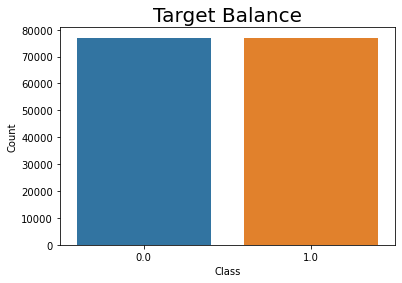

In [227]:
ax  = sns.barplot(x = y_train_os.unique(),  y = y_train_os.value_counts());
ax.set(xlabel='Class', ylabel='Count')
plt.title('Target Balance', size = 20);

Scale

In [228]:
# use standard scaler for the first pass
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

# scale data - train + test, first fit
standard_scaler.fit(X_train_os)
X_train_os_ss = standard_scaler.transform(X_train_os)
X_test_ss = standard_scaler.transform(X_test)

PCA

In [229]:
# PCA first to look at the data - reduce dimensions
from sklearn.decomposition import PCA

# fit and transform
pca = PCA(n_components=X_train_os_ss.shape[1])
pca.fit(X_train_os_ss)  # _ss is scaled data
X_train_os_ss_PCA = pca.transform(X_train_os_ss)
X_test_ss_PCA = pca.transform(X_test_ss)

In [230]:
expl_var = pca.explained_variance_ratio_
print(expl_var[15])

0.0021947027983790766


In [231]:
print(f'The first 11 PCA dimensions provide {np.cumsum(expl_var)[10]}')

The first 11 PCA dimensions provide 0.9694836183678213


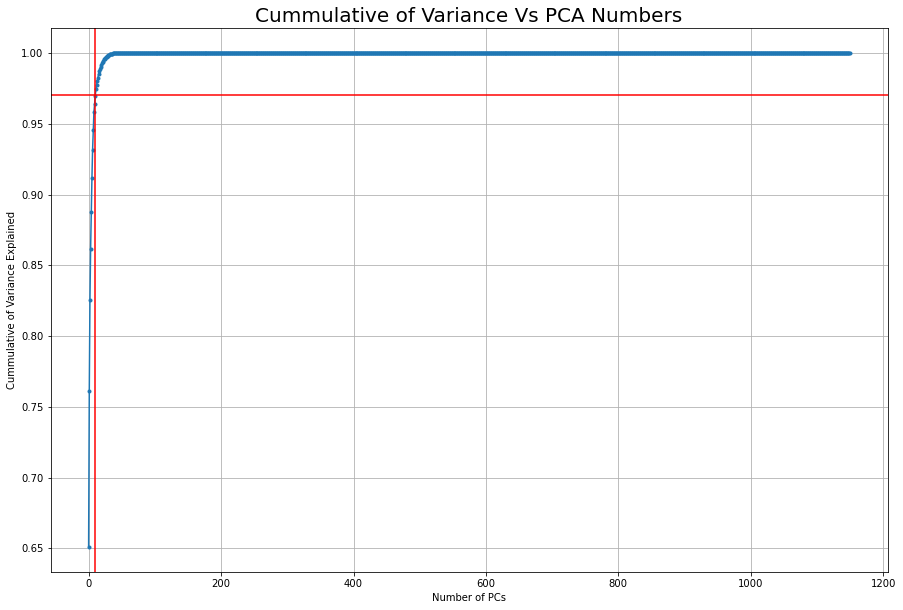

In [237]:
plt.figure(figsize=(15, 10))

plt.plot(range(0, 1150), np.cumsum(expl_var), marker='.')
plt.axhline(y=0.97, c='red')  # mark 95% cum variance
plt.axvline(x=10, c='red')  # mark PCAs at 95% cum variance
plt.xlabel('Number of PCs')
plt.ylabel('Cummulative of Variance Explained')
# plt.xticks(range(0,200,100))
plt.grid()
plt.title('Cummulative of Variance Vs PCA Numbers', size=20)

plt.show()

Let us look at the first and second components.

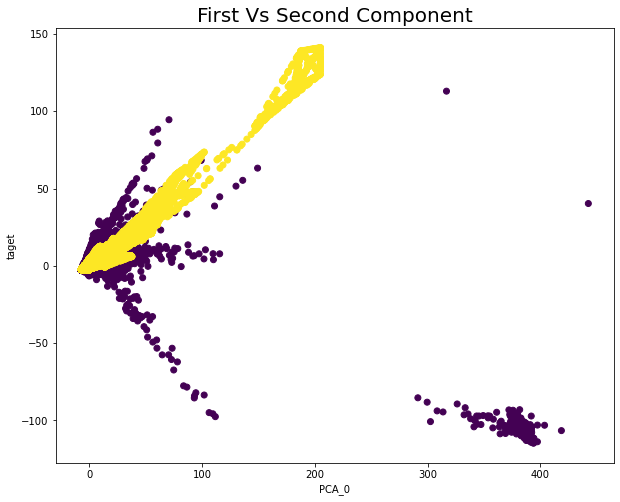

In [238]:
plt.figure(figsize  = (10,8))

plt.scatter(X_train_os_ss_PCA[:,0],X_train_os_ss_PCA[:,1], c=y_train_os)
plt.xlabel('PCA_0')
plt.ylabel('PCA_1')
plt.title('First Vs Second Component', size = 20)
plt.ylabel('taget')

plt.show()

Great, there appears to be a clear separation with some overlap.

In [239]:
# extract the first 11 dimensions only, we will call it PCA_10 while it should be called PCA_11
# fit and transform
pca = PCA(n_components=10)
pca.fit(X_train_os_ss) # _ss is scaled data
X_train_os_ss_PCA10 = pca.transform(X_train_os_ss)
X_test_ss_PCA10 = pca.transform(X_test_ss)

Log Regression

In [ ]:
# Logistic regression

In [240]:
# instantiate and fit the logistic model
from sklearn.linear_model import LogisticRegression

# max_iteration param set to 1000
log_model = LogisticRegression(solver='lbfgs', C=1, max_iter=1000)
log_model.fit(X_train_os_ss_PCA10, y_train_os)

# Score the logistic regression model
print(f'The model accuracy score on the train data is {round(log_model.score(X_train_os_ss_PCA10, y_train_os),4)}.')
print(f'The model accuracy score on the test data is {round(log_model.score(X_test_ss_PCA10, y_test),4)}.')

The model accuracy score on the train data is 0.6342.
The model accuracy score on the test data is 0.8229.


In [241]:
log_model.coef_

array([[ 0.0359803 ,  0.2370067 , -0.02425674, -0.02566261, -0.04201509,
        -0.02659621,  0.070187  ,  0.01234394, -0.35930488, -0.0477381 ]])

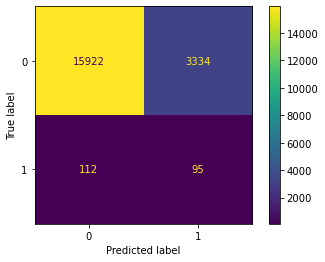

In [242]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predict, generate the confusion matrix and plot the heatmeap
y_pred = log_model.predict(X_test_ss_PCA10)

confusion_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix).plot()
plt.show()

In [243]:
print(f'Model Precision score is {round(precision_recall_f1_scores(y_test, y_pred)[0],3)}.')
print(f'Model Recall score is {round(precision_recall_f1_scores(y_test, y_pred)[1],3)}.')
print(f'Model f1-score is {round(precision_recall_f1_scores(y_test, y_pred)[2],3)}.')

Model Precision score is 0.028.
Model Recall score is 0.459.
Model f1-score is 0.052.


Low Precision and Recall scores, but this is the linear model. At this stage, the following has been done:
- Data for epochs of 6 seconds, 2 seconds, 1 second, and 0.25 seconds were transformed and models were fitted, but the results were not better, the code has been omitted for brevity.
- SVM model was run, results were better but marginally, the code has been omitted for brevity.

The notbook has become heavy and consuming high memory, the work is continued on another notebook `3_Modelling_Detection`

# Summary

By now, the following was done:
- Features were extracted for dataset_1, plotting the features, the classes did not seem to be separable.
- Few `epoch` window length were tried, no improvement.
- Statistical time domain features were tried, no improvement either.
- Initial modelling showed poor result.
- Dataset_2 was then tried, better result were obtained on the initial modelling.

On the next notebook `3_Modelling_Detection`, we will explore improving dataset_2 models, before working on the Prediction problem on `4_Modelling_Prediction`. 